# Project 2

# Table of Contents

[Preliminary analysis on collected local data ](#1)

[Local data + Features ](#2)

[Training and testing local data ](#3)

[Training and testing community data ](#4)

[Testing local/community models on sniffer data  ](#5)

[Bonus ](#6)

[How to use our model for testing / predictions ](#7)

[Appendix ](#8)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
from joblib import dump, load
import re
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix

ImportError: cannot import name 'plot_confusion_matrix'

-----------------------------------------
## Preliminary analysis on collected local data 
<a id='1'></a>
In this section, we wanted to investigate what type of model (Random Forest, SVM, or Lostical Regression) would be the most promising. Additionally, we also wanted to find out what packet protocols should we train on given the relaxed conditions. This section does relate to the Bonus task. 

We trained a prelimary model with no features utlising RF, SVM, and LR for each possible combination of protocols (HTTP, UDP, TLS, TCP). Here are the results. For code snippet see Appendix 1.1

In [2]:
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095', 'lr': '0.1419901106352015'}, 'df_http_tcp_udp': {'rf': '0.2037161108863077', 'svm': '0.3820788197599984', 'lr': '0.17080046965485676'}, 'df_http_tls': {'rf': '0.3097651891070538', 'svm': '0.3443101688074266', 'lr': '0.1738170421899855'}, 'df_http_tls_tcp': {'rf': '0.18547421547378568', 'svm': '0.1963357053828537', 'lr': '0.16377579527104605'}, 'df_http_tls_tcp_udp': {'rf': '0.20156217562798423', 'svm': '0.22305376790533527', 'lr': '0.1523354785135977'}, 'df_http_tls_udp': {'rf': '0.29559293757820104', 'svm': '0.34468233004309745', 'lr': '0.18623661893507576'}, 'df_http_udp': {'rf': '0.31467715590519685', 'svm': '0.37464582152738424', 'lr': '0.42851428380946033'}, 'df_tcp': {'rf': '0.157879917184265', 'svm': '0.3526128364389234', 'lr': '0.14200414078674947'}, 'df_tcp_udp': {'rf': '0.20305391170356202', 'svm': '0.382223816260519', 'lr': '0.16926029981203633'}, 'df_tls': {'rf': '0.3133242708258806', 'svm': '0.34489995468746276', 'lr': '0.17462020939161957'}, 'df_tls_tcp': {'rf': '0.1880490038787566', 'svm': '0.19629827699608435', 'lr': '0.16386056146691994'}, 'df_tls_tcp_udp': {'rf': '0.20558256966523283', 'svm': '0.22301186542817364', 'lr': '0.153668723895019'}, 'df_tls_udp': {'rf': '0.2972596247665245', 'svm': '0.34498620055197793', 'lr': '0.18620891527975245'}, 'df_udp': {'rf': '0.3150179463956258', 'svm': '0.3753647982288417', 'lr': '0.4282311898292577'}}

{'all': {'rf': '0.20282841849532876',
  'svm': '0.22171087716526103',
  'lr': '0.1613749037113117'},
 'df_http': {'rf': '0.32978723404255317',
  'svm': '0.3404255319148936',
  'lr': '0.21808510638297873'},
 'df_http_tcp': {'rf': '0.15967685921711952',
  'svm': '0.3526352345830095',
  'lr': '0.1419901106352015'},
 'df_http_tcp_udp': {'rf': '0.2037161108863077',
  'svm': '0.3820788197599984',
  'lr': '0.17080046965485676'},
 'df_http_tls': {'rf': '0.3097651891070538',
  'svm': '0.3443101688074266',
  'lr': '0.1738170421899855'},
 'df_http_tls_tcp': {'rf': '0.18547421547378568',
  'svm': '0.1963357053828537',
  'lr': '0.16377579527104605'},
 'df_http_tls_tcp_udp': {'rf': '0.20156217562798423',
  'svm': '0.22305376790533527',
  'lr': '0.1523354785135977'},
 'df_http_tls_udp': {'rf': '0.29559293757820104',
  'svm': '0.34468233004309745',
  'lr': '0.18623661893507576'},
 'df_http_udp': {'rf': '0.31467715590519685',
  'svm': '0.37464582152738424',
  'lr': '0.42851428380946033'},
 'df_tcp': {'

Given these preliminary results, we then plotted the training accuracies for each model type (SVM, RF, LR), for each combination of protocols (HTTP, UDP, TCP, TLS).

#### Accuracy of the 3 models with different subset of packets types

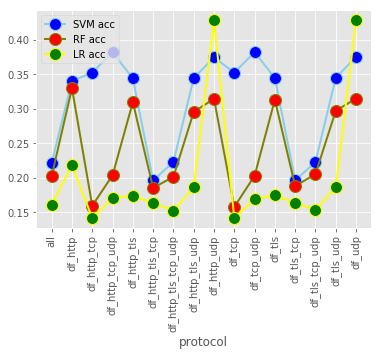

In [44]:
x_key = svm_key = list(map(lambda x : x[0], svm_results))
x_pos = [i for i, _ in enumerate(x_key)]

svm_results = [(k, r['svm']) for k,r in results.items()]
svm_val = list(map(lambda x : float(x[1]), svm_results))

rf_results = [(k, r['rf']) for k,r in results.items()]
rf_val = list(map(lambda x : float(x[1]), rf_results))

lr_results =  [(k, r['lr']) for k,r in results.items()]
lr_val = list(map(lambda x : float(x[1]), lr_results))

# multiple line plot
plt.plot(x_pos, svm_val, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=2, label='SVM acc')
plt.plot(x_pos, rf_val, marker='o', markerfacecolor='red', markersize=12, color='olive', linewidth=2, label='RF acc')
plt.plot(x_pos, lr_val, marker='o', markerfacecolor='green', markersize=12, color='yellow', linewidth=2, label='LR acc')
plt.xticks(x_pos, x_key, rotation='vertical')
plt.xlabel("protocol")
plt.ylabel("Accuracy")

plt.legend()

Additionally, we also wanted to see what the average accuracy of the 3 model types are

#### Average accuracy of the 3 model types

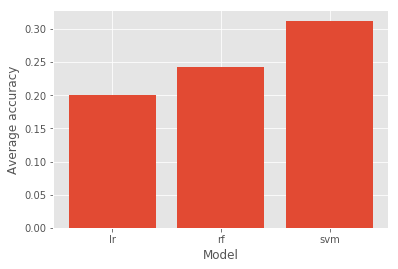

In [47]:
lr_av = np.mean(lr_val)
rf_av = np.mean(rf_val)
svm_av = np.mean(svm_val)
plt.bar([0,1,2], [lr_av, rf_av, svm_av])
plt.xticks([0,1,2], ['lr', 'rf', 'svm'])
plt.xlabel("Model")
plt.ylabel("Average accuracy")

plt.show()

As we can see from the plot above, using UDP with Logistical Regression (LR) seems to provide the best results. 

However, averaging out across protocols, LR performs the worst. 

We also want to verify the impact on accuracy depending on the protocol used. 

To do this we calculate the average accuracies for each model type (lr, rf, svm) for each model that uses http, udp, tls, tcp protocols. 

For example, we calculate the average accuracy given model type SVM that uses UDP packets (this includes the following data sets: UDP, HTTP + UDP, TCP + UDP, UDP + TCO + TLS, etc.)

In [87]:
# For HTTP, TCP, UDP, TLS, plot their average accuracy on each of the 3 models
# x-axis: protcols that uses http, tcp, udp, or tls
# y-axis average accuracy on for models that used that protocol
http = [d for d in x_key if d.find("http") >= 0]
udp = [d for d in x_key if d.find("udp") >= 0]
tls = [d for d in x_key if d.find("tls") >= 0]
tcp = [d for d in x_key if d.find("tcp") >= 0]

# print(http)
# print(udp)
# print(tls)
# print(tcp)

http_svm_val = [r['svm'] for k,r in results.items() if k in http]
udp_svm_val = [r['svm'] for k,r in results.items() if k in udp]
tls_svm_val = [r['svm'] for k,r in results.items() if k in tls]
tcp_svm_val = [r['svm'] for k,r in results.items() if k in tcp]

http_lr_val = [r['lr'] for k,r in results.items() if k in http]
udp_lr_val = [r['lr'] for k,r in results.items() if k in udp]
tls_lr_val = [r['lr'] for k,r in results.items() if k in tls]
tcp_lr_val = [r['lr'] for k,r in results.items() if k in tcp]

http_rf_val = [r['rf'] for k,r in results.items() if k in http]
udp_rf_val = [r['rf'] for k,r in results.items() if k in udp]
tls_rf_val = [r['rf'] for k,r in results.items() if k in tls]
tcp_rf_val = [r['rf'] for k,r in results.items() if k in tcp]

http_svm_av = np.mean(list(map(lambda x: float(x), http_svm_val)))
http_lr_av = np.mean(list(map(lambda x: float(x), http_lr_val)))
http_rf_av = np.mean(list(map(lambda x: float(x), http_rf_val)))

udp_svm_av = np.mean(list(map(lambda x: float(x), udp_svm_val)))
udp_lr_av = np.mean(list(map(lambda x: float(x), udp_lr_val)))
udp_rf_av = np.mean(list(map(lambda x: float(x), udp_rf_val)))

tls_svm_av = np.mean(list(map(lambda x: float(x), tls_svm_val)))
tls_lr_av = np.mean(list(map(lambda x: float(x), tls_lr_val)))
tls_rf_av = np.mean(list(map(lambda x: float(x), tls_rf_val)))

tcp_svm_av = np.mean(list(map(lambda x: float(x), tcp_svm_val)))
tcp_lr_av = np.mean(list(map(lambda x: float(x), tcp_lr_val)))
tcp_rf_av = np.mean(list(map(lambda x: float(x), tcp_rf_val)))


from IPython.display import HTML, display
import tabulate
table = [["","SVM","LR", "RF"],
         ["HTTP", http_svm_av, http_lr_av, http_rf_av],
         ["UDP", udp_svm_av, udp_lr_av, udp_rf_av],
         ["TLS", tls_svm_av, tls_lr_av, tls_rf_av],
         ["TCP",tcp_svm_av, tcp_lr_av, tcp_rf_av]
        ]

print("Average accuracy of protocol usage against model")
display(HTML(tabulate.tabulate(table, tablefmt='html', floatfmt=(".4f", ".4f", ".4f"))))

# We would also want to normalize it by the average proportion of protocol packtes in each dataset that the protocol was part of

Average accuracy of protocol usage against model


,SVM,LR,RF
HTTP,0.3197709224904999,0.2044443631740253,0.2500314847297752
UDP,0.33125592746316596,0.23440699746613203,0.2545578040660794
TLS,0.2771972837253015,0.16931541811787698,0.2495762483654274
TCP,0.2885312903443622,0.15721194750442835,0.1881243454546267


From the table above, it seems like HTTP and UDP plays a big role in SVM. 

However, findings in this table must be taken with a grain of salt as protocol usage is very skewed in the data i.e. a data collection might have 4 HTTP packets and hundreds of UDP.



-----------------------------------------
## Local data + Features
<a id='2'></a>


Since we decided to use HTTP + UDP packets for our local data training, we import them below

In [3]:
# Local data
path = "collection/"
folder = "df_http_udp/" # specify which packet protocol config you want here
col_names = ["website-index", "time", "direction", "packet size"]
df_one_local = pd.read_csv(path+folder+"Day1-parsed-ondevice.csv", header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False, quotechar='^')
df_two_local = pd.read_csv(path+folder+"Day2-parsed-ondevice.csv", header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False, quotechar='^')
df_three_local = pd.read_csv(path+folder+"Day3-parsed-ondevice.csv", header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False, quotechar='^')

We then proceeded with feature engineering. We chose the following features: 

- Cumulative representation of trace
- Cumulative Counting Statistics
    - Counting cumulative packets
    - Counting incoming cmulative packets 
    - Counting outgoing cumulative packets 
    - Counting cumulative percentage of outgoing/incoming packets 
- Previous 100 packet sizes
- Total Counting statistics
- Packet ordering statistics 
- Concentration of incoming & outgoing packets in first and last 30 packets 
- Concentration of outgoing packets 

All of the code for feature engineering can be found at the bottom of this document, in Appendix #2.1, along with their descriptions.

We do howerver, include a plot here of cumulative model accuracy (Random Forest) for each feature mentioned above

Text(0, 0.5, 'Cumulative Accuracy')

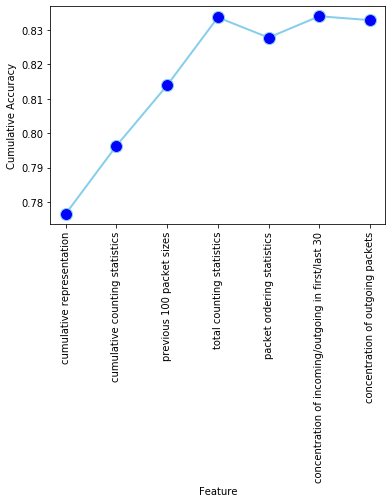

In [4]:
x_key = ['cumulative representation', 'cumulative counting statistics', 'previous 100 packet sizes', 'total counting statistics', 'packet ordering statistics', 'concentration of incoming/outgoing in first/last 30', 'concentration of outgoing packets']
x_pos = [i for i, _ in enumerate(x_key)]
y_val = [0.7765592186406214, 0.7963265442181406, 0.813893796459882, 0.8336277875929198, 0.8277609253641788, 0.8339611320377346, 0.8328277609253641]

# multiple line plot
plt.plot(x_pos, y_val, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=2, label='SVM acc')

plt.xticks(x_pos, x_key, rotation='vertical')
plt.xlabel("Feature")
plt.ylabel("Cumulative Accuracy")

-----------------------------------------
## Training and testing local data 
<a id='3'></a>

#### Local HTTP UDP data import

In [29]:
# Local data
path = "collection/"
folder = "df_http_udp/" # specify which packet protocol config you want here
col_names = ["website-index", "time", "direction", "packet size"]
df_one_local = pd.r#### Local HTTP UDP data importead_csv(path+folder+"Day1-parsed-ondevice.csv", header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False, quotechar='^')
df_two_local = pd.read_csv(path+folder+"Day2-parsed-ondevice.csv", header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False, quotechar='^')
df_three_local = pd.read_csv(path+folder+"Day3-parsed-ondevice.csv", header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False, quotechar='^')

#### Local All protocols data import

In [32]:
# Local data
path = "collection/"
folder = "all/" # specify which packet protocol config you want here
col_names = ["website-index", "time", "direction", "packet size"]
df_one_local_all = pd.read_csv(path+folder+"Day1-parsed-ondevice.csv", header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False, quotechar='^')
df_two_local_all = pd.read_csv(path+folder+"Day2-parsed-ondevice.csv", header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False, quotechar='^')
df_three_local_all = pd.read_csv(path+folder+"Day3-parsed-ondevice.csv", header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False, quotechar='^')

#### Preprocessing the imported data

In [30]:
df_one_stat = outgoing_concentration(df_one_local, prev=True)
df_two_stat = outgoing_concentration(df_two_local, prev=True)
df_three_stat = outgoing_concentration(df_three_local, prev=True)

In [33]:
df_one_stat_all = outgoing_concentration(df_one_local_all, prev=True)
df_two_stat_all = outgoing_concentration(df_two_local_all, prev=True)
df_three_stat_all = outgoing_concentration(df_three_local_all, prev=True)

#### Assessing the model accuracy (Random forest of HTTP+UDP)

In [18]:
run_model(df_one_stat, df_two_stat, df_three_stat)

RF acc: 0.8336611220374013
KNN acc: 0.7305576852561753


#### Assessing the model accuracy (Random forest of All protocols)

In [36]:
run_model(df_one_stat_all, df_two_stat_all, df_three_stat_all)

RF acc: 0.36447984356791563
KNN acc: 0.17476150032590018


As we can see from the above output, we reach an accuracy of about 83% using the aforementioned features with HTTP + UDP

Our model with all features performs very poorly.

#### Model confusion matrix (Local HTTP + UDP)

In [31]:
local_rf_model = get_rf_model(df_one_stat.append(df_two_stat))
dump(local_rf_model, 'local_rf_model')

['local_rf_model']

In [25]:
# Preprocess testing data
X_test = df_three_stat.loc[:, df_three_stat.columns != 'website-index']
y_test = df_three_stat['website-index']

RF acc: 0.8336277875929198


Text(0.5, 1.0, 'Local HTTP UDP RF model Confusion Matrix')

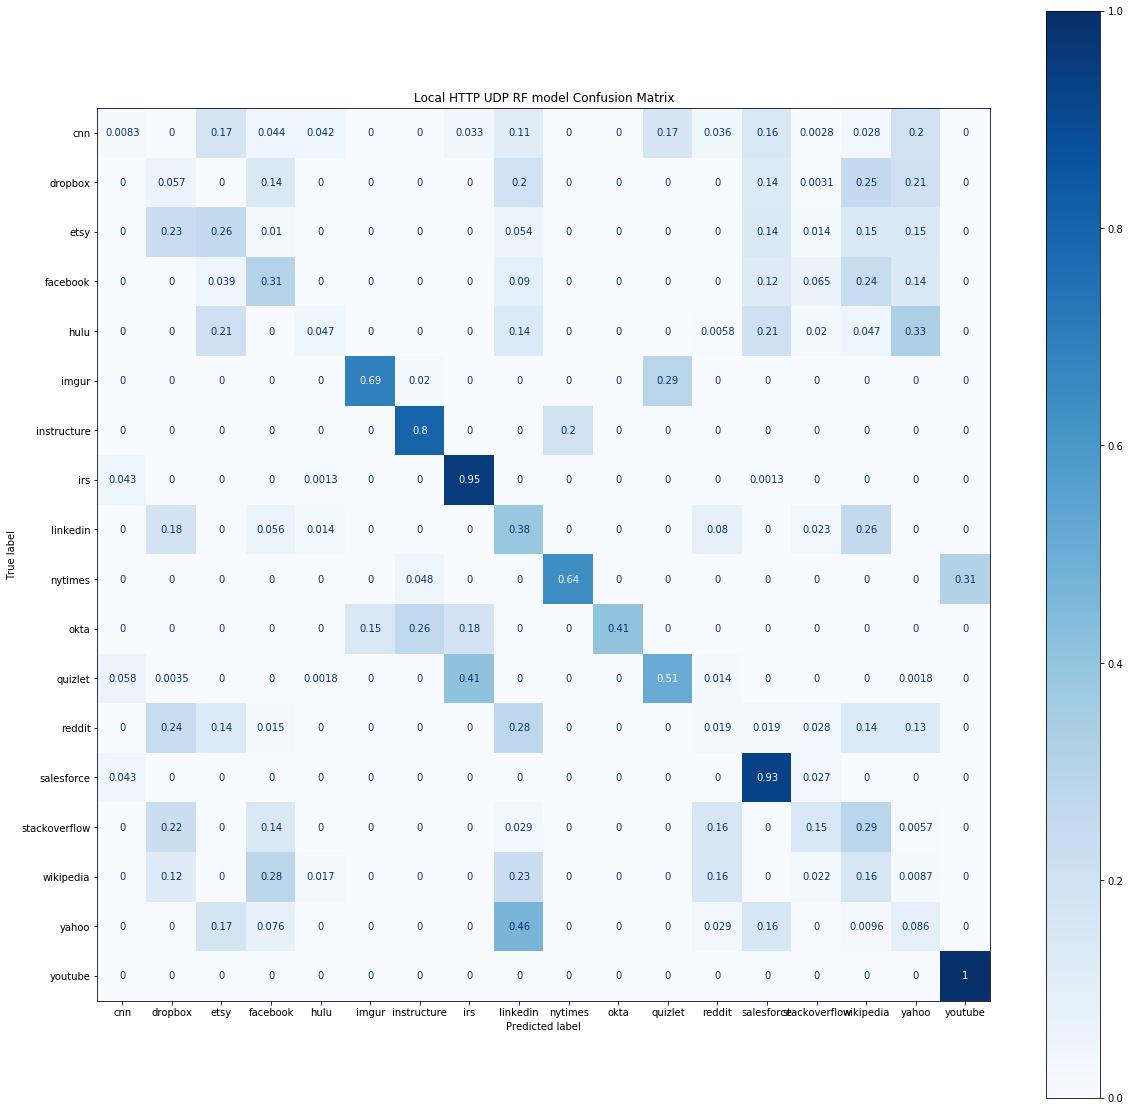

In [26]:
rf_acc = local_rf_model.score(X_test, y_test)
print("RF acc: " + str(rf_acc))

fig, ax = plt.subplots(figsize=(20, 20))
title = "Local HTTP UDP RF model Confusion Matrix"
disp = plot_confusion_matrix(local_rf_model, X_test, y_test,
                             cmap=plt.cm.Blues,
                             ax=ax,
                             normalize='true')
disp.ax_.set_title(title)

#### Model confusion matrix (Local All protocols)

In [42]:
local_rf_model_all = get_rf_model(df_one_stat_all.append(df_two_stat_all))
dump(local_rf_model_all, 'local_rf_model_all')

['local_rf_model_all']

In [43]:
# Preprocess testing data
X_test = df_three_stat_all.loc[:, df_three_stat_all.columns != 'website-index']
y_test = df_three_stat_all['website-index']

RF acc: 0.3672598708250212


Text(0.5, 1.0, 'Local All protocols RF model Confusion Matrix')

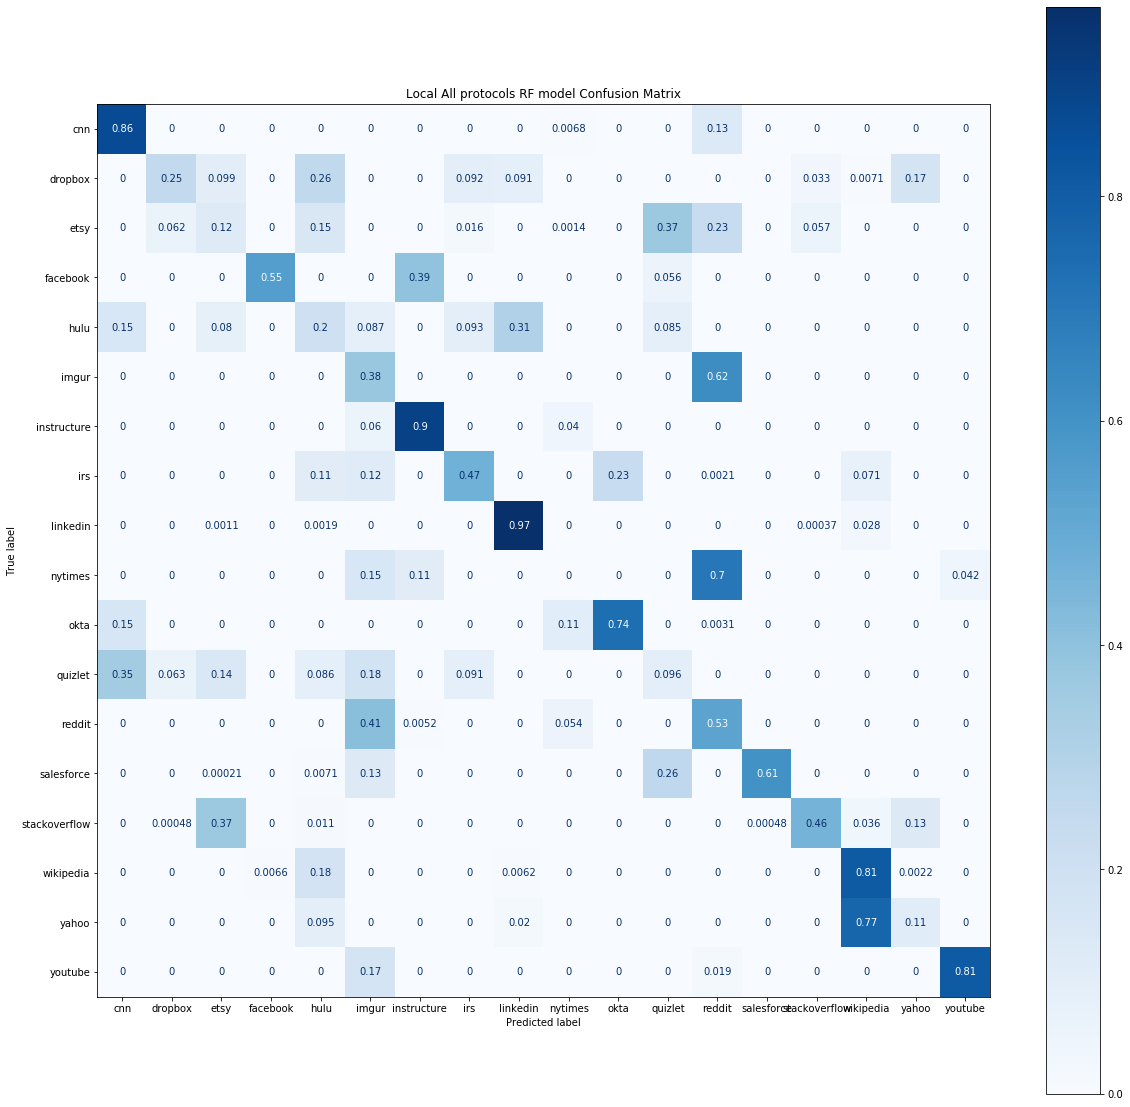

In [44]:
rf_acc = local_rf_model_all.score(X_test, y_test)
print("RF acc: " + str(rf_acc))

fig, ax = plt.subplots(figsize=(20, 20))
title = "Local All protocols RF model Confusion Matrix"
disp = plot_confusion_matrix(local_rf_model_all, X_test, y_test,
                             cmap=plt.cm.Blues,
                             ax=ax,
                             normalize='true')
disp.ax_.set_title(title)

## Training and testing community data
<a id='4'></a>

Import tls/http community data & preprocess it or import pickled data, train the model, and evaluate it.

##### Import data (TLS)

In [39]:
# Community data import (make sure to have path with access to parsed community data)

# choose /tls/ vs /http/
path="community_data/parsed_on_device/tls/"

day_one="day_1"
day_two="day_2"
day_three="day_3"
file="_fixed.csv"
col_names = ["website-index", "time", "direction", "packet size"]

df_one_tls = pd.read_csv(path+day_one+file, header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False)
df_two_tls = pd.read_csv(path+day_two+file, header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False)
df_three_tls = pd.read_csv(path+day_three+file, header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False)

##### Import data (HTTP)

In [19]:
# Community data import (make sure to have path with access to parsed community data)

# choose /tls/ vs /http/
path="community_data/parsed_on_device/http/"

day_one="day_1"
day_two="day_2"
day_three="day_3"
file="_fixed.csv"
col_names = ["website-index", "time", "direction", "packet size"]

df_one_http = pd.read_csv(path+day_one+file, header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False)
df_two_http = pd.read_csv(path+day_two+file, header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False)
df_three_http = pd.read_csv(path+day_three+file, header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False)

##### Preprocess or load from disk

In [40]:
# Add the features
df_one_tls = outgoing_concentration(df_one_tls, prev=True)
df_two_tls = outgoing_concentration(df_two_tls, prev=True)
df_three_tls = outgoing_concentration(df_three_tls, prev=True)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [20]:
# Add the features
df_one_http = outgoing_concentration(df_one_http, prev=True)
df_two_http = outgoing_concentration(df_two_http, prev=True)
df_three_http = outgoing_concentration(df_three_http, prev=True)

In [2]:
# Write to disk
# df_one.to_pickle("./community_data/df_one_community_tls.pkl")
# df_two.to_pickle("./community_data/df_two_community_tls.pkl")
# df_three.to_pickle("./community_data/df_three_community_tls.pkl")

In [3]:
# Read from disk
df_one_tls = pd.read_pickle("./community_data/df_one_community_tls.pkl")
df_two_tls = pd.read_pickle("./community_data/df_two_community_tls.pkl")
df_three_tls = pd.read_pickle("./community_data/df_three_community_tls.pkl")

#### HTTP

In [35]:
run_model(df_one_http, df_two_http, df_three_http)

RF acc: 0.09543886546569567
KNN acc: 0.11153698735147566


#### TLS

In [41]:
run_model(df_one_tls, df_two_tls, df_three_tls)

RF acc: 0.821889752651762
KNN acc: 0.2074660965906478


As you can see, the random forest model performs well on the TLS community data with all the features, but the other model's performance on just HTTP is quite poor. 

#### Evaluate confusion matrix / accuracy for HTTP

In [21]:
# Get trained model to evaluate
df = df_one_http.append(df_two_http)
X = df.loc[:, df.columns != 'website-index']
y = df['website-index']
X_test = df_three_http.loc[:, df_three_http.columns != 'website-index']
y_test = df_three_http['website-index']

clf_http = get_rf_model(df)

RF acc: 0.0931391337677271


Text(0.5, 1.0, 'Community HTTP: Confusion Matrix')

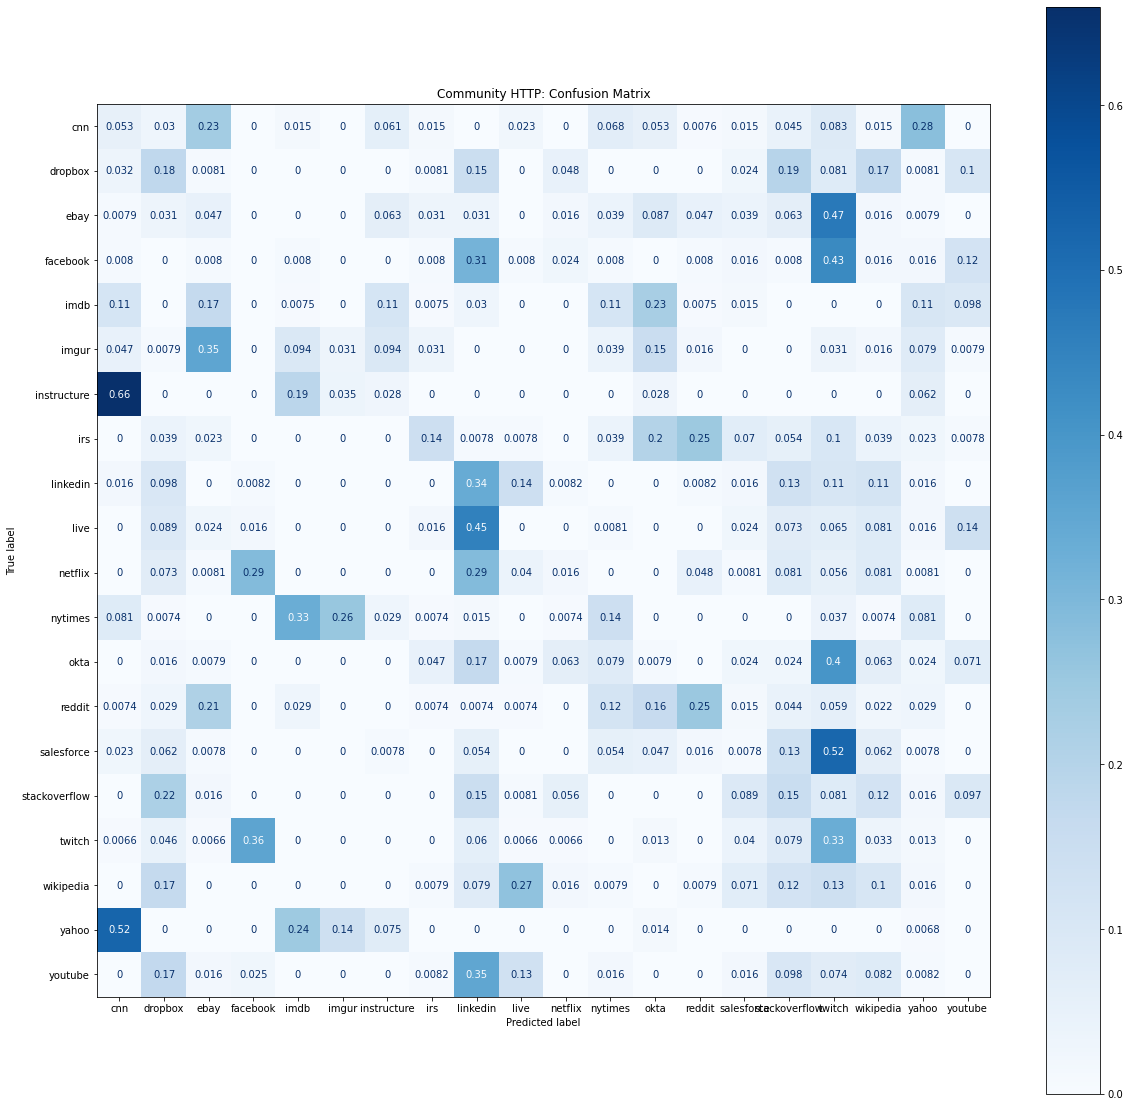

In [22]:
rf_acc = clf_http.score(X_test, y_test)
print("RF acc: " + str(rf_acc))

fig, ax = plt.subplots(figsize=(20, 20))
title = "Community HTTP: Confusion Matrix"
disp = plot_confusion_matrix(clf_http, X_test, y_test,
                             cmap=plt.cm.Blues,
                             ax=ax,
                             normalize='true')
disp.ax_.set_title(title)

#### Evaluate confusion matrix / accuracy for TLS


In [5]:
# Preprocess training data
df = df_one_tls.append(df_two_tls)
X = df.loc[:, df.columns != 'website-index']
y = df['website-index']

# Preprocess testing data
X_test = df_three_tls.loc[:, df_three_tls.columns != 'website-index']
y_test = df_three_tls['website-index']

In [7]:
clf_tls = get_rf_model(df)

Text(0.5, 1.0, 'Community TLS: Confusion Matrix')

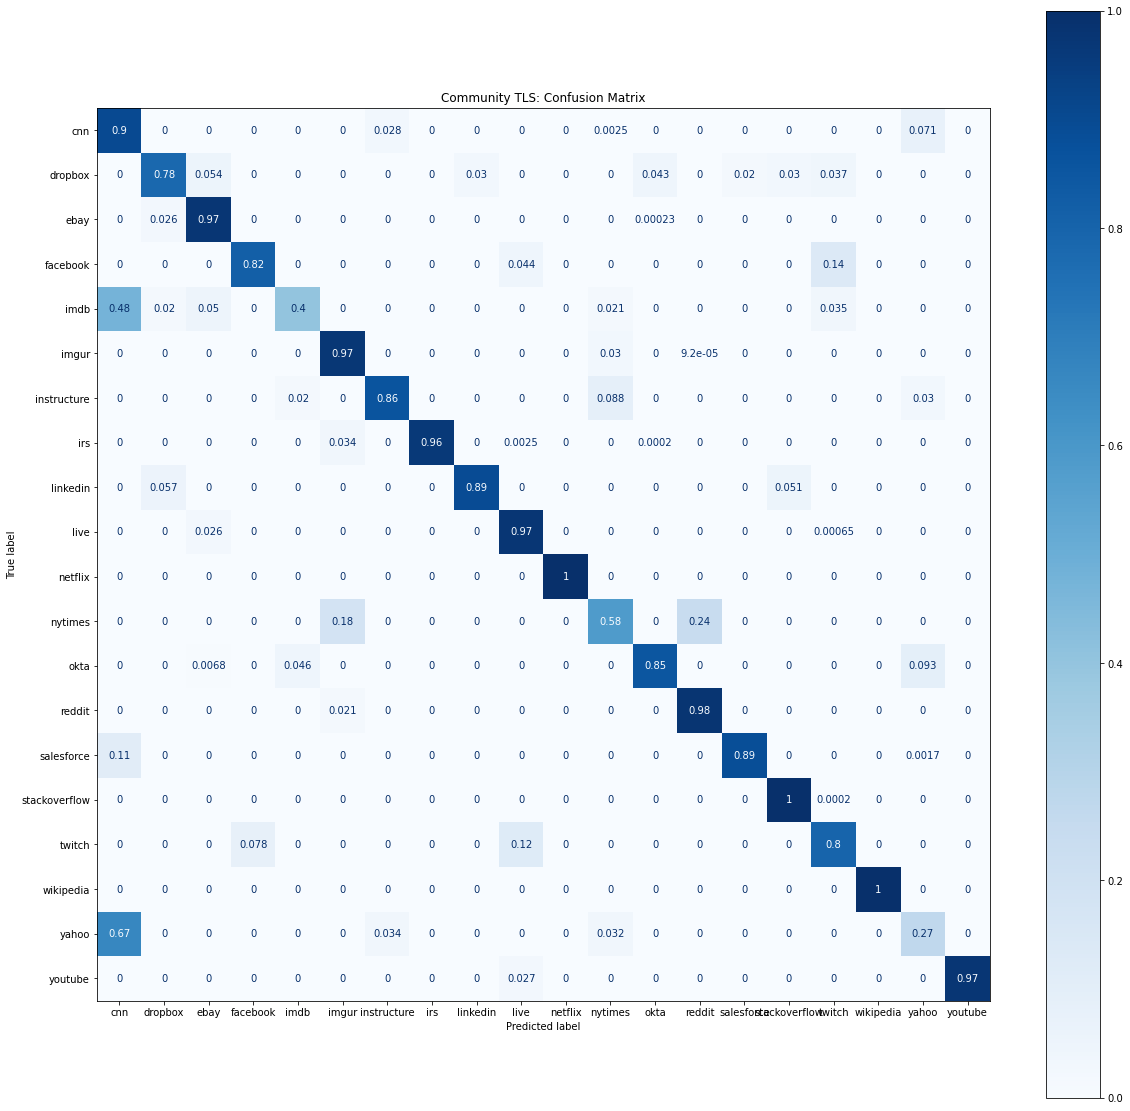

In [16]:
rf_acc = clf_tls.score(X_test, y_test)
print("RF acc: " + str(rf_acc))

fig, ax = plt.subplots(figsize=(20, 20))
title = "Community TLS: Confusion Matrix"
disp = plot_confusion_matrix(clf_tls, X_test, y_test,
                             cmap=plt.cm.Blues,
                             ax=ax,
                             normalize='true')
disp.ax_.set_title(title)

In [ ]:
# Preprocess testing data
X_test = df_three_tls.loc[:, df_three.columns != 'website-index']
y_test = df_three_tls['website-index']

In [ ]:
clf_http = get_rf_model(df_one_http.append(df_two_http))

In [ ]:
rf_acc = clf_tls.score(X_test, y_test)
print("RF acc: " + str(rf_acc))

fig, ax = plt.subplots(figsize=(20, 20))
title = "Community HTTP: Confusion Matrix"
disp = plot_confusion_matrix(clf_tls, X_test, y_test,
                             cmap=plt.cm.Blues,
                             ax=ax,
                             normalize='true')
disp.ax_.set_title(title)

-----------------------------------------

# Testing local/community model on sniffer data
<a id='5'></a>


In [17]:
def get_rf_model(df): 
    # Preprocess training data
    X = df.loc[:, df.columns != 'website-index']
    y = df['website-index']

    # Model training
    clf = RandomForestClassifier(n_estimators=300, n_jobs=-1 )
    # Change n_estimators to what you want (defualt 100)
    # n_jobs=-1 will run the classifier on ALL cpu's, lower this if running on bad comp
    
    return clf.fit(X,y)

def get_knn_model(df):
    # Preprocess training data
    X = df.loc[:, df.columns != 'website-index']
    y = df['website-index']
    
    # Model training 
    knn = KNeighborsClassifier(n_neighbors=20)
    return knn.fit(X,y)

### Local data model

Note: we import on-device data, train the model, and then run the sniffer data against the trained model.

#### Train the model on local on-device data (all or http_udp)

In [46]:
# Local data
path = "collection/"
folder = "df_http_udp/" # specify which packet protocol config you want here
col_names = ["website-index", "time", "direction", "packet size"]
df_one_local = pd.read_csv(path+folder+"Day1-parsed-ondevice.csv", header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False, quotechar='^')
df_two_local = pd.read_csv(path+folder+"Day2-parsed-ondevice.csv", header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False, quotechar='^')
df_three_local = pd.read_csv(path+folder+"Day3-parsed-ondevice.csv", header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False, quotechar='^')

In [47]:
# Add the features
df_one_local = outgoing_concentration(df_one_local, prev=True)
df_two_local = outgoing_concentration(df_two_local, prev=True)
df_three_local = outgoing_concentration(df_three_local, prev=True)

In [48]:
# Get the trained model 
local_rf_model = get_rf_model(df_one_local.append(df_two_local)) 
local_knn_model = get_knn_model(df_one_local.append(df_two_local))

#### Run the sniffer data against trained model on all local on-device packets

In [44]:
# Run local on-device model against sniffer data
path = "community_data/parsed_sniffer/"
columns = ['website-index', 'time', 'direction', 'packet size']
acc_rfs = []
acc_knns = []

print("[note] Model training protocol configuration: all packets")
for filename in os.listdir(path):
    # Preprocess: construct df per website 
    website = re.search(r"(.*)-([1-2])-.*", filename).group(1)
    df = pd.read_csv(path + filename,names=columns, header=0)
    df['direction'] = df['direction'].astype(int)
    df = outgoing_concentration(df, prev=True)

    X_test = df.loc[:, df.columns != 'website-index']
    y_test = df['website-index']
    
    # Evaluate on sniffer data
    acc_rf = local_rf_model.score(X_test, y_test)
    acc_rfs.append(acc_rf)
    print("RF {}: {:.2f}".format(website, acc_rf))
    
    acc_knn = local_knn_model.score(X_test, y_test)
    acc_knns.append(acc_knn)
    print("KNN {}: {:.2f}".format(website, acc_knn))
    
print('RF mean acc', np.mean(acc_rfs))
print('KNN mean acc', np.mean(acc_knns))

# Evaluate the models again against local on-device data (day3)
X_test = df_three_local.loc[:, df.columns != 'website-index']
y_test = df_three_local['website-index']
day_3_rf_acc = local_rf_model.score(X_test, y_test)
day_3_knn_acc = local_knn_model.score(X_test, y_test)
print('\nIn comparison with local on-device data: ')
print('RF acc:', day_3_rf_acc)
print('KNN acc:', day_3_knn_acc)

[note] Model training protocol configuration: all packets
RF nytimes: 0.00
KNN nytimes: 0.00
RF salesforce: 0.00
KNN salesforce: 0.01
RF salesforce: 0.00
KNN salesforce: 0.00
RF nytimes: 0.00
KNN nytimes: 0.00
RF dropbox: 0.00
KNN dropbox: 0.15
RF youtube: 1.00
KNN youtube: 0.09
RF hulu: 0.00
KNN hulu: 0.03
RF linkedin: 0.00
KNN linkedin: 0.06
RF okta: 0.00
KNN okta: 0.17
RF quizlet: 0.00
KNN quizlet: 0.01
RF reddit: 0.00
KNN reddit: 0.00
RF quizlet: 0.00
KNN quizlet: 0.01
RF reddit: 0.14
KNN reddit: 0.12
RF youtube: 0.00
KNN youtube: 0.08
RF dropbox: 0.00
KNN dropbox: 0.01
RF okta: 0.00
KNN okta: 0.04
RF linkedin: 0.00
KNN linkedin: 0.01
RF hulu: 0.00
KNN hulu: 0.23
RF cnn: 0.00
KNN cnn: 0.02
RF instructure: 0.00
KNN instructure: 0.06
RF homedepot: 0.00
KNN homedepot: 0.00
RF instructure: 0.00
KNN instructure: 0.01
RF homedepot: 0.00
KNN homedepot: 0.00
RF cnn: 0.00
KNN cnn: 0.04
RF stackoverflow: 0.00
KNN stackoverflow: 0.03
RF facebook: 0.00
KNN facebook: 0.00
RF etsy: 0.00
KNN etsy

#### Run the sniffer data against trained model on HTTP_UDP on-device packets 

In [49]:
# Run local on-device model against sniffer data
path = "community_data/parsed_sniffer/"
columns = ['website-index', 'time', 'direction', 'packet size']
acc_rfs = []
acc_knns = []

print("[note] Model training protocol configuration: df_http_udp packets")
for filename in os.listdir(path):
    # Preprocess: construct df per website 
    website = re.search(r"(.*)-([1-2])-.*", filename).group(1)
    df = pd.read_csv(path + filename,names=columns, header=0)
    df['direction'] = df['direction'].astype(int)
    df = outgoing_concentration(df, prev=True)

    X_test = df.loc[:, df.columns != 'website-index']
    y_test = df['website-index']
    
    # Evaluate on sniffer data
    acc_rf = local_rf_model.score(X_test, y_test)
    acc_rfs.append(acc_rf)
    print("RF {}: {:.2f}".format(website, acc_rf))
    
    acc_knn = local_knn_model.score(X_test, y_test)
    acc_knns.append(acc_knn)
    print("KNN {}: {:.2f}".format(website, acc_knn))
    
print('RF mean acc', np.mean(acc_rfs))
print('KNN mean acc', np.mean(acc_knns))

# Evaluate the models again against local on-device data (day3)
X_test = df_three_local.loc[:, df.columns != 'website-index']
y_test = df_three_local['website-index']
day_3_rf_acc = local_rf_model.score(X_test, y_test)
day_3_knn_acc = local_knn_model.score(X_test, y_test)
print('\nIn comparison with local on-device data: ')
print('RF acc:', day_3_rf_acc)
print('KNN acc:', day_3_knn_acc)

[note] Model training protocol configuration: df_http_udp packets
RF nytimes: 0.00
KNN nytimes: 0.03
RF salesforce: 0.00
KNN salesforce: 0.00
RF salesforce: 1.00
KNN salesforce: 0.00
RF nytimes: 0.00
KNN nytimes: 0.00
RF dropbox: 0.00
KNN dropbox: 0.27
RF youtube: 0.00
KNN youtube: 0.04
RF hulu: 0.00
KNN hulu: 0.52
RF linkedin: 0.00
KNN linkedin: 0.00
RF okta: 0.00
KNN okta: 0.01
RF quizlet: 1.00
KNN quizlet: 0.09
RF reddit: 0.00
KNN reddit: 0.00
RF quizlet: 1.00
KNN quizlet: 0.04
RF reddit: 0.00
KNN reddit: 0.00
RF youtube: 0.00
KNN youtube: 0.00
RF dropbox: 0.00
KNN dropbox: 0.06
RF okta: 0.00
KNN okta: 0.00
RF linkedin: 0.00
KNN linkedin: 0.00
RF hulu: 0.00
KNN hulu: 0.22
RF cnn: 0.00
KNN cnn: 0.01
RF instructure: 0.00
KNN instructure: 0.01
RF homedepot: 0.00
KNN homedepot: 0.00
RF instructure: 0.00
KNN instructure: 0.01
RF homedepot: 0.00
KNN homedepot: 0.00
RF cnn: 0.00
KNN cnn: 0.04
RF stackoverflow: 0.00
KNN stackoverflow: 0.00
RF facebook: 0.00
KNN facebook: 0.01
RF etsy: 0.00


## Community data model

Note: we import on-device data, train the model, and then run the sniffer data against the trained model.

#### Train the model on community on-device data (http or tls)

In [14]:
# Community data import (make sure to have path with access to parsed community data)

# choose /tls/ vs /http/
path="community_data/parsed_on_device/http/"

day_one="day_1"
day_two="day_2"
day_three="day_3"
file="_fixed.csv"
col_names = ["website-index", "time", "direction", "packet size"]

df_one_community = pd.read_csv(path+day_one+file, header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False)
df_two_community = pd.read_csv(path+day_two+file, header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False)
df_three_community = pd.read_csv(path+day_three+file, header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False)

In [15]:
# Add the features
df_one_community = outgoing_concentration(df_one_community, prev=True)
df_two_community = outgoing_concentration(df_two_community, prev=True)
df_three_community = outgoing_concentration(df_three_community, prev=True)

In [52]:
# Read TLS disk if you have the pickles
df_one_community = pd.read_pickle("./community_data/df_one_community_tls.pkl")
df_two_community = pd.read_pickle("./community_data/df_two_community_tls.pkl")
df_three_community = pd.read_pickle("./community_data/df_three_community_tls.pkl")

In [18]:
# Get the trained model 
community_rf_model = get_rf_model(df_one_community.append(df_two_community)) 
community_knn_model = get_knn_model(df_one_community.append(df_two_community))

#### Run the sniffer data against HTTP-trained model

In [59]:
# Run community on-device model against sniffer data
path = "community_data/parsed_sniffer/"
columns = ['website-index', 'time', 'direction', 'packet size']
acc_rfs = []
acc_knns = []

print("[note] Model training protocol configuration: http packets")
for filename in os.listdir(path):
    # Preprocess: construct df per website 
    website = re.search(r"(.*)-([1-2])-.*", filename).group(1)
    df = pd.read_csv(path + filename,names=columns, header=0)
    df['direction'] = df['direction'].astype(int)
    df = outgoing_concentration(df, prev=True)

    X_test = df.loc[:, df.columns != 'website-index']
    y_test = df['website-index']
    
    # Evaluate on sniffer data
    acc_rf = local_rf_model.score(X_test, y_test)
    acc_rfs.append(acc_rf)
    print("RF {}: {:.2f}".format(website, acc_rf))
    
    acc_knn = local_knn_model.score(X_test, y_test)
    acc_knns.append(acc_knn)
    print("KNN {}: {:.2f}".format(website, acc_knn))
    
print('RF mean acc', np.mean(acc_rfs))
print('KNN mean acc', np.mean(acc_knns))

# Evaluate the models again against local on-device data (day3)
X_test = df_three_community.loc[:, df.columns != 'website-index']
y_test = df_three_community['website-index']
day_3_rf_acc = local_rf_model.score(X_test, y_test)
day_3_knn_acc = local_knn_model.score(X_test, y_test)
print('\nIn comparison with community on-device data: ')
print('RF acc:', day_3_rf_acc)
print('KNN acc:', day_3_knn_acc)

[note] Model training protocol configuration: http packets
RF nytimes: 0.00
KNN nytimes: 0.03
RF salesforce: 0.00
KNN salesforce: 0.00
RF salesforce: 1.00
KNN salesforce: 0.00
RF nytimes: 0.00
KNN nytimes: 0.00
RF dropbox: 0.00
KNN dropbox: 0.27
RF youtube: 0.00
KNN youtube: 0.04
RF hulu: 0.00
KNN hulu: 0.52
RF linkedin: 0.00
KNN linkedin: 0.00
RF okta: 0.00
KNN okta: 0.01
RF quizlet: 1.00
KNN quizlet: 0.09
RF reddit: 0.00
KNN reddit: 0.00
RF quizlet: 1.00
KNN quizlet: 0.04
RF reddit: 0.00
KNN reddit: 0.00
RF youtube: 0.00
KNN youtube: 0.00
RF dropbox: 0.00
KNN dropbox: 0.06
RF okta: 0.00
KNN okta: 0.00
RF linkedin: 0.00
KNN linkedin: 0.00
RF hulu: 0.00
KNN hulu: 0.22
RF cnn: 0.00
KNN cnn: 0.01
RF instructure: 0.00
KNN instructure: 0.01
RF homedepot: 0.00
KNN homedepot: 0.00
RF instructure: 0.00
KNN instructure: 0.01
RF homedepot: 0.00
KNN homedepot: 0.00
RF cnn: 0.00
KNN cnn: 0.04
RF stackoverflow: 0.00
KNN stackoverflow: 0.00
RF facebook: 0.00
KNN facebook: 0.01
RF etsy: 0.00
KNN ets

#### Run the sniffer data against HTTP-trained model TLS packets

In [55]:
# Run community on-device model against sniffer data
path = "community_data/parsed_sniffer/"
columns = ['website-index', 'time', 'direction', 'packet size']
acc_rfs = []
acc_knns = []

print("[note] Model training protocol configuration: tls packets")
for filename in os.listdir(path):
    # Preprocess: construct df per website 
    website = re.search(r"(.*)-([1-2])-.*", filename).group(1)
    df = pd.read_csv(path + filename,names=columns, header=0)
    df['direction'] = df['direction'].astype(int)
    df = outgoing_concentration(df, prev=True)

    X_test = df.loc[:, df.columns != 'website-index']
    y_test = df['website-index']
    
    # Evaluate on sniffer data
    acc_rf = local_rf_model.score(X_test, y_test)
    acc_rfs.append(acc_rf)
    print("RF {}: {:.2f}".format(website, acc_rf))
    
    acc_knn = local_knn_model.score(X_test, y_test)
    acc_knns.append(acc_knn)
    print("KNN {}: {:.2f}".format(website, acc_knn))
    
print('RF mean acc', np.mean(acc_rfs))
print('KNN mean acc', np.mean(acc_knns))

# Evaluate the models again against local on-device data (day3)
X_test = df_three_community.loc[:, df.columns != 'website-index']
y_test = df_three_community['website-index']
day_3_rf_acc = local_rf_model.score(X_test, y_test)
day_3_knn_acc = local_knn_model.score(X_test, y_test)
print('\nIn comparison with community on-device data: ')
print('RF acc:', day_3_rf_acc)
print('KNN acc:', day_3_knn_acc)

[note] Model training protocol configuration: tls packets
RF nytimes: 0.00
KNN nytimes: 0.03
RF salesforce: 0.00
KNN salesforce: 0.00
RF salesforce: 1.00
KNN salesforce: 0.00
RF nytimes: 0.00
KNN nytimes: 0.00
RF dropbox: 0.00
KNN dropbox: 0.27
RF youtube: 0.00
KNN youtube: 0.04
RF hulu: 0.00
KNN hulu: 0.52
RF linkedin: 0.00
KNN linkedin: 0.00
RF okta: 0.00
KNN okta: 0.01
RF quizlet: 1.00
KNN quizlet: 0.09
RF reddit: 0.00
KNN reddit: 0.00
RF quizlet: 1.00
KNN quizlet: 0.04
RF reddit: 0.00
KNN reddit: 0.00
RF youtube: 0.00
KNN youtube: 0.00
RF dropbox: 0.00
KNN dropbox: 0.06
RF okta: 0.00
KNN okta: 0.00
RF linkedin: 0.00
KNN linkedin: 0.00
RF hulu: 0.00
KNN hulu: 0.22
RF cnn: 0.00
KNN cnn: 0.01
RF instructure: 0.00
KNN instructure: 0.01
RF homedepot: 0.00
KNN homedepot: 0.00
RF instructure: 0.00
KNN instructure: 0.01
RF homedepot: 0.00
KNN homedepot: 0.00
RF cnn: 0.00
KNN cnn: 0.04
RF stackoverflow: 0.00
KNN stackoverflow: 0.00
RF facebook: 0.00
KNN facebook: 0.01
RF etsy: 0.00
KNN etsy

-----------------------------------------
# Bonus 
<a id='6'></a>


So far we have done an preliminary investgation as to what protocol combination is the best to use. However, we've only done our analysis on the local data. Here we perform a similar analysis through the community data. 

Unfortunately due to the large size of community data, we don't have the time to train models of all 3 types (SVM, RF, LR). We decided to only use Random Forests as it's the model type that we've chosen for the rest of the project. 

In [2]:
col_names = ["website-index", "time", "direction", "packet size"]
folders = []
path = './Community Data Version 2/collection/'
for r, d, f in os.walk(path):
    for folder in d:
        folders.append(folder)

results = {}

# Loop over the folders in /collection
for folder in folders:
    print(folder)
    if (folder == "raw"):
        continue 
    results[folder] = {} # Goddam python dictionaries

    # Load data into dataframes
    df_one = pd.read_csv(path+"/"+folder+"/"+"day_1_parsed.csv", header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False, quotechar='^')
    df_two = pd.read_csv(path+"/"+folder+"/"+"day_2_parsed.csv", header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False, quotechar='^')
    df_three = pd.read_csv(path+"/"+folder+"/"+"day_3_parsed.csv", header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False, quotechar='^')
    
    # Preprocess training data
    df = df_one.append(df_two)
    X = df.loc[:, df.columns != 'website-index']
    y = df['website-index']
    
    # Preprocess testing data
    X_test = df_three.loc[:, df_three.columns != 'website-index']
    y_test = df_three['website-index']
    
    outpath = './models/' + folder + "/"
    if not os.path.exists(outpath):
        os.mkdir(outpath)    

    # RF model training
    clf = RandomForestClassifier(n_jobs=-1)
    clf.fit(X,y)
    rf_acc = clf.score(X_test, y_test)
    print("RF acc: " + str(rf_acc))
    results[folder]["rf"] = str(rf_acc)
#     dump(clf, outpath + 'rf_model.joblib')
    print(results)

# SVM + LR Takes too long, we have too much data for community 
    
#     # SVM model training
#     svm_model = svm.SVC(verbose=True, cache_size=8000) # Yes i have the ram
#     svm_model.fit(X, y)
#     svm_acc = svm_model.score(X_test, y_test)
#     print("SVM acc: " + str(svm_acc))
#     results[folder]["svm"] = str(svm_acc)
# #     dump(svm_model, outpath + 'svm_model.joblib')
#     print(results)

#     # LR model training
#     lr = LogisticRegression(random_state=0, max_iter=10e5, n_jobs=-1)
#     lr.fit(X, y)
#     lr_acc = lr.score(X_test, y_test)
#     print("Logistic Reg acc: " + str(lr_acc))
#     results[folder]["lr"] = str(lr_acc)
# #     dump(lr, outpath + "lr_model.joblib")
#     print(results)

df_all
RF acc: 0.14868995019526254
{'df_all': {'rf': '0.14868995019526254'}}
df_http
RF acc: 0.062476044461479495
{'df_all': {'rf': '0.14868995019526254'}, 'df_http': {'rf': '0.062476044461479495'}}
df_http_tcp
RF acc: 0.14689377543861254
{'df_all': {'rf': '0.14868995019526254'}, 'df_http': {'rf': '0.062476044461479495'}, 'df_http_tcp': {'rf': '0.14689377543861254'}}
df_http_tcp_udp
RF acc: 0.12372394731711099
{'df_all': {'rf': '0.14868995019526254'}, 'df_http': {'rf': '0.062476044461479495'}, 'df_http_tcp': {'rf': '0.14689377543861254'}, 'df_http_tcp_udp': {'rf': '0.12372394731711099'}}
df_http_tls
RF acc: 0.24324581239249998
{'df_all': {'rf': '0.14868995019526254'}, 'df_http': {'rf': '0.062476044461479495'}, 'df_http_tcp': {'rf': '0.14689377543861254'}, 'df_http_tcp_udp': {'rf': '0.12372394731711099'}, 'df_http_tls': {'rf': '0.24324581239249998'}}
df_http_tls_tcp
RF acc: 0.17748836145925478
{'df_all': {'rf': '0.14868995019526254'}, 'df_http': {'rf': '0.062476044461479495'}, 'df_http_

In [7]:
rf_values = [results[key]['rf'] for key in results.keys()]
rf_keys = [key for key in results.keys()]


['df_all',
 'df_http',
 'df_http_tcp',
 'df_http_tcp_udp',
 'df_http_tls',
 'df_http_tls_tcp',
 'df_http_tls_tcp_udp',
 'df_http_tls_udp',
 'df_http_udp',
 'df_tcp',
 'df_tcp_udp',
 'df_tls',
 'df_tls_tcp',
 'df_tls_tcp_udp',
 'df_tls_udp',
 'df_udp']

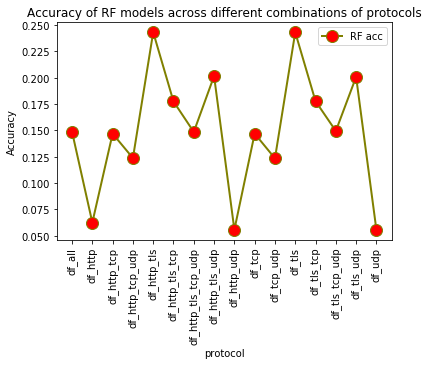

In [9]:
x_key = rf_keys
x_pos = [i for i, _ in enumerate(x_key)]

rf_results = [(k, r['rf']) for k,r in results.items()]
rf_val = list(map(lambda x : float(x[1]), rf_results))

# multiple line plot
plt.plot(x_pos, rf_val, marker='o', markerfacecolor='red', markersize=12, color='olive', linewidth=2, label='RF acc')
plt.xticks(x_pos, x_key, rotation='vertical')
plt.xlabel("protocol")
plt.ylabel("Accuracy")
plt.title("Accuracy of RF models across different combinations of protocols")
plt.legend()

In [14]:
rf_av = np.mean(rf_val)
print("Average RF accuracy across all protocol combinations:")
print(rf_av)

Average RF accuracy across all protocol combinations:
0.1503345542759575


From the graph above, we see that HTTP + TLS and TLS seems to be the best protocol combination. This is in conflict with our local data results where UDP seems to be the best predictor. Though the peak accuracy here is just 25%, as compared to local data of ~35%. The average RF accuracy between all protocol combinations is also significantly lower in community data as compared to local (15% vs 25-35%). 

It would seem that there is significantly more noise in the community data than local, given that the community data is double in size of the local data despite accessing the same websites for the same number of runs. 

Our conclusion here for the final section is that an individual should focus on UDP packets in a relatively low noise scenario, and focusing on TLS when noise is of greater concern.

We hypotheisze that since TLS is very prominent for website access, this would reduce the amount of noise for identifying traffic corresponding to website access. Conversely, when noise is little, UDP packets would give a good solid packet size fingerprint for website content delivery.

----------------------------

# How to use our model for testing / predicting
<a id='7'></a>


Steps
0. `from utils import preprocess, reformat`, load up model
1. Read input, testing files into pandas dataframes i.e. `df_testing`
2. Preprocess dataframe by calling `preprocess(df_testing)` on the input dataframe. This essentially adds all of our pre-defined features, the code is exactly the same as shown in the appendix
3. Reformat `df_input` for model application by calling `reformat(df_input)`
4. Use `rf_model.predict()` or `rf_model.score()` to see model in action

See cell below for example

In [3]:
from utils import preprocess, reformat

local_rf_model = load('./local_rf_model')
col_names = ["website-index", "time", "direction", "packet size"]

# Example of process
df_input = pd.read_csv("./collection/df_udp/Day3-parsed-ondevice.csv", header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False)
preprocessed = preprocess(df_input)
X, Y = reformat(preprocessed)
local_rf_model.score(X, Y)


0.8402603065982356

--------------------------------------

# Appendix
<a id='8'></a>

Here we show our work and our iterations to reach the results shown earlier. 

### 1.1

In [2]:
col_names = ["website-index", "time", "direction", "packet size"]
folders = []
for r, d, f in os.walk(path):
    for folder in d:
        folders.append(folder)

results = {}

# Loop over the folders in /collection
for folder in folders:
    if (folder == "raw"):
        continue 
    results[folder] = {} # Goddam python dictionaries

    # Load data into dataframes
    df_one = pd.read_csv(path+"/"+folder+"/"+"Day1-parsed-ondevice.csv", header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False, quotechar='^')
    df_two = pd.read_csv(path+"/"+folder+"/"+"Day2-parsed-ondevice.csv", header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False, quotechar='^')
    df_three = pd.read_csv(path+"/"+folder+"/"+"Day3-parsed-ondevice.csv", header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False, quotechar='^')
    
    # Preprocess training data
    df = df_one.append(df_two)
    X = df.loc[:, df.columns != 'website-index']
    y = df['website-index']
    
    # Preprocess testing data
    X_test = df_three.loc[:, df_three.columns != 'website-index']
    y_test = df_three['website-index']
    
    outpath = './models/' + folder + "/"
    if not os.path.exists(outpath):
        os.mkdir(outpath)    

    # RF model training
    clf = RandomForestClassifier(n_jobs=-1)
    clf.fit(X,y)
    rf_acc = clf.score(X_test, y_test)
    print("RF acc: " + str(rf_acc))
    results[folder]["rf"] = str(rf_acc)
    dump(clf, outpath + 'rf_model.joblib')
    print(results)

    # SVM model training
    svm_model = svm.SVC(verbose=True, cache_size=8000) # Yes i have the ram
    svm_model.fit(X, y)
    svm_acc = svm_model.score(X_test, y_test)
    print("SVM acc: " + str(svm_acc))
    results[folder]["svm"] = str(svm_acc)
    dump(svm_model, outpath + 'svm_model.joblib')
    print(results)

    # LR model training
    lr = LogisticRegression(random_state=0, max_iter=10e5, n_jobs=-1)
    lr.fit(X, y)
    lr_acc = lr.score(X_test, y_test)
    print("Logistic Reg acc: " + str(lr_acc))
    results[folder]["lr"] = str(lr_acc)
    dump(lr, outpath + "lr_model.joblib")
    print(results)

all


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF acc: 0.20282841849532876
{'all': {'rf': '0.20282841849532876'}}
[LibSVM]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM acc: 0.22171087716526103
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103'}}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Logistic Reg acc: 0.1613749037113117
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}}
df_http


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF acc: 0.32978723404255317
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317'}}
[LibSVM]SVM acc: 0.3404255319148936
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936'}}
Logistic Reg acc: 0.21808510638297873
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}}
df_http_tcp


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Prog

RF acc: 0.15967685921711952
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952'}}
[LibSVM]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM acc: 0.3526352345830095
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095'}}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Logistic Reg acc: 0.1419901106352015
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095', 'lr': '0.1419901106352015'}}
df_http_tcp_udp


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF acc: 0.2037161108863077
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095', 'lr': '0.1419901106352015'}, 'df_http_tcp_udp': {'rf': '0.2037161108863077'}}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]SVM acc: 0.3820788197599984
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095', 'lr': '0.1419901106352015'}, 'df_http_tcp_udp': {'rf': '0.2037161108863077', 'svm': '0.3820788197599984'}}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Logistic Reg acc: 0.17080046965485676
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095', 'lr': '0.1419901106352015'}, 'df_http_tcp_udp': {'rf': '0.2037161108863077', 'svm': '0.3820788197599984', 'lr': '0.17080046965485676'}}
df_http_tls


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF acc: 0.3097651891070538
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095', 'lr': '0.1419901106352015'}, 'df_http_tcp_udp': {'rf': '0.2037161108863077', 'svm': '0.3820788197599984', 'lr': '0.17080046965485676'}, 'df_http_tls': {'rf': '0.3097651891070538'}}
[LibSVM]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM acc: 0.3443101688074266
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095', 'lr': '0.1419901106352015'}, 'df_http_tcp_udp': {'rf': '0.2037161108863077', 'svm': '0.3820788197599984', 'lr': '0.17080046965485676'}, 'df_http_tls': {'rf': '0.3097651891070538', 'svm': '0.3443101688074266'}}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Logistic Reg acc: 0.1738170421899855
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095', 'lr': '0.1419901106352015'}, 'df_http_tcp_udp': {'rf': '0.2037161108863077', 'svm': '0.3820788197599984', 'lr': '0.17080046965485676'}, 'df_http_tls': {'rf': '0.3097651891070538', 'svm': '0.3443101688074266', 'lr': '0.1738170421899855'}}
df_http_tls_tcp


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF acc: 0.18547421547378568
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095', 'lr': '0.1419901106352015'}, 'df_http_tcp_udp': {'rf': '0.2037161108863077', 'svm': '0.3820788197599984', 'lr': '0.17080046965485676'}, 'df_http_tls': {'rf': '0.3097651891070538', 'svm': '0.3443101688074266', 'lr': '0.1738170421899855'}, 'df_http_tls_tcp': {'rf': '0.18547421547378568'}}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]SVM acc: 0.1963357053828537
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095', 'lr': '0.1419901106352015'}, 'df_http_tcp_udp': {'rf': '0.2037161108863077', 'svm': '0.3820788197599984', 'lr': '0.17080046965485676'}, 'df_http_tls': {'rf': '0.3097651891070538', 'svm': '0.3443101688074266', 'lr': '0.1738170421899855'}, 'df_http_tls_tcp': {'rf': '0.18547421547378568', 'svm': '0.1963357053828537'}}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Logistic Reg acc: 0.16377579527104605
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095', 'lr': '0.1419901106352015'}, 'df_http_tcp_udp': {'rf': '0.2037161108863077', 'svm': '0.3820788197599984', 'lr': '0.17080046965485676'}, 'df_http_tls': {'rf': '0.3097651891070538', 'svm': '0.3443101688074266', 'lr': '0.1738170421899855'}, 'df_http_tls_tcp': {'rf': '0.18547421547378568', 'svm': '0.1963357053828537', 'lr': '0.16377579527104605'}}
df_http_tls_tcp_udp


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF acc: 0.20156217562798423
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095', 'lr': '0.1419901106352015'}, 'df_http_tcp_udp': {'rf': '0.2037161108863077', 'svm': '0.3820788197599984', 'lr': '0.17080046965485676'}, 'df_http_tls': {'rf': '0.3097651891070538', 'svm': '0.3443101688074266', 'lr': '0.1738170421899855'}, 'df_http_tls_tcp': {'rf': '0.18547421547378568', 'svm': '0.1963357053828537', 'lr': '0.16377579527104605'}, 'df_http_tls_tcp_udp': {'rf': '0.20156217562798423'}}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]SVM acc: 0.22305376790533527
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095', 'lr': '0.1419901106352015'}, 'df_http_tcp_udp': {'rf': '0.2037161108863077', 'svm': '0.3820788197599984', 'lr': '0.17080046965485676'}, 'df_http_tls': {'rf': '0.3097651891070538', 'svm': '0.3443101688074266', 'lr': '0.1738170421899855'}, 'df_http_tls_tcp': {'rf': '0.18547421547378568', 'svm': '0.1963357053828537', 'lr': '0.16377579527104605'}, 'df_http_tls_tcp_udp': {'rf': '0.20156217562798423', 'svm': '0.22305376790533527'}}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Logistic Reg acc: 0.1523354785135977
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095', 'lr': '0.1419901106352015'}, 'df_http_tcp_udp': {'rf': '0.2037161108863077', 'svm': '0.3820788197599984', 'lr': '0.17080046965485676'}, 'df_http_tls': {'rf': '0.3097651891070538', 'svm': '0.3443101688074266', 'lr': '0.1738170421899855'}, 'df_http_tls_tcp': {'rf': '0.18547421547378568', 'svm': '0.1963357053828537', 'lr': '0.16377579527104605'}, 'df_http_tls_tcp_udp': {'rf': '0.20156217562798423', 'svm': '0.22305376790533527', 'lr': '0.1523354785135977'}}
df_http_tls_udp


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF acc: 0.29559293757820104
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095', 'lr': '0.1419901106352015'}, 'df_http_tcp_udp': {'rf': '0.2037161108863077', 'svm': '0.3820788197599984', 'lr': '0.17080046965485676'}, 'df_http_tls': {'rf': '0.3097651891070538', 'svm': '0.3443101688074266', 'lr': '0.1738170421899855'}, 'df_http_tls_tcp': {'rf': '0.18547421547378568', 'svm': '0.1963357053828537', 'lr': '0.16377579527104605'}, 'df_http_tls_tcp_udp': {'rf': '0.20156217562798423', 'svm': '0.22305376790533527', 'lr': '0.1523354785135977'}, 'df_http_tls_udp': {'rf': '0.29559293757820104'}}
[LibSVM]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM acc: 0.34468233004309745
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095', 'lr': '0.1419901106352015'}, 'df_http_tcp_udp': {'rf': '0.2037161108863077', 'svm': '0.3820788197599984', 'lr': '0.17080046965485676'}, 'df_http_tls': {'rf': '0.3097651891070538', 'svm': '0.3443101688074266', 'lr': '0.1738170421899855'}, 'df_http_tls_tcp': {'rf': '0.18547421547378568', 'svm': '0.1963357053828537', 'lr': '0.16377579527104605'}, 'df_http_tls_tcp_udp': {'rf': '0.20156217562798423', 'svm': '0.22305376790533527', 'lr': '0.1523354785135977'}, 'df_http_tls_udp': {'rf': '0.29559293757820104', 'svm': '0.34468233004309745'}}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Logistic Reg acc: 0.18623661893507576
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095', 'lr': '0.1419901106352015'}, 'df_http_tcp_udp': {'rf': '0.2037161108863077', 'svm': '0.3820788197599984', 'lr': '0.17080046965485676'}, 'df_http_tls': {'rf': '0.3097651891070538', 'svm': '0.3443101688074266', 'lr': '0.1738170421899855'}, 'df_http_tls_tcp': {'rf': '0.18547421547378568', 'svm': '0.1963357053828537', 'lr': '0.16377579527104605'}, 'df_http_tls_tcp_udp': {'rf': '0.20156217562798423', 'svm': '0.22305376790533527', 'lr': '0.1523354785135977'}, 'df_http_tls_udp': {'rf': '0.29559293757820104', 'svm': '0.34468233004309745', 'lr': '0.18623661893507576'}}
df_http_udp


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF acc: 0.31467715590519685
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095', 'lr': '0.1419901106352015'}, 'df_http_tcp_udp': {'rf': '0.2037161108863077', 'svm': '0.3820788197599984', 'lr': '0.17080046965485676'}, 'df_http_tls': {'rf': '0.3097651891070538', 'svm': '0.3443101688074266', 'lr': '0.1738170421899855'}, 'df_http_tls_tcp': {'rf': '0.18547421547378568', 'svm': '0.1963357053828537', 'lr': '0.16377579527104605'}, 'df_http_tls_tcp_udp': {'rf': '0.20156217562798423', 'svm': '0.22305376790533527', 'lr': '0.1523354785135977'}, 'df_http_tls_udp': {'rf': '0.29559293757820104', 'svm': '0.34468233004309745', 'lr': '0.18623661893507576'}, 'df_http_udp': {'rf': '0.31467715590519685'}}
[LibSVM]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM acc: 0.37464582152738424
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095', 'lr': '0.1419901106352015'}, 'df_http_tcp_udp': {'rf': '0.2037161108863077', 'svm': '0.3820788197599984', 'lr': '0.17080046965485676'}, 'df_http_tls': {'rf': '0.3097651891070538', 'svm': '0.3443101688074266', 'lr': '0.1738170421899855'}, 'df_http_tls_tcp': {'rf': '0.18547421547378568', 'svm': '0.1963357053828537', 'lr': '0.16377579527104605'}, 'df_http_tls_tcp_udp': {'rf': '0.20156217562798423', 'svm': '0.22305376790533527', 'lr': '0.1523354785135977'}, 'df_http_tls_udp': {'rf': '0.29559293757820104', 'svm': '0.34468233004309745', 'lr': '0.18623661893507576'}, 'df_http_udp': {'rf': '0.31467715590519685', 'svm': '0.37464582152738424'}}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Logistic Reg acc: 0.42851428380946033
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095', 'lr': '0.1419901106352015'}, 'df_http_tcp_udp': {'rf': '0.2037161108863077', 'svm': '0.3820788197599984', 'lr': '0.17080046965485676'}, 'df_http_tls': {'rf': '0.3097651891070538', 'svm': '0.3443101688074266', 'lr': '0.1738170421899855'}, 'df_http_tls_tcp': {'rf': '0.18547421547378568', 'svm': '0.1963357053828537', 'lr': '0.16377579527104605'}, 'df_http_tls_tcp_udp': {'rf': '0.20156217562798423', 'svm': '0.22305376790533527', 'lr': '0.1523354785135977'}, 'df_http_tls_udp': {'rf': '0.29559293757820104', 'svm': '0.34468233004309745', 'lr': '0.18623661893507576'}, 'df_http_udp': {'rf': '0.31467715590519685', 'svm': '0.37464582152738424', 'lr': '0.42851428380946033'}}
df_tcp


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF acc: 0.157879917184265
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095', 'lr': '0.1419901106352015'}, 'df_http_tcp_udp': {'rf': '0.2037161108863077', 'svm': '0.3820788197599984', 'lr': '0.17080046965485676'}, 'df_http_tls': {'rf': '0.3097651891070538', 'svm': '0.3443101688074266', 'lr': '0.1738170421899855'}, 'df_http_tls_tcp': {'rf': '0.18547421547378568', 'svm': '0.1963357053828537', 'lr': '0.16377579527104605'}, 'df_http_tls_tcp_udp': {'rf': '0.20156217562798423', 'svm': '0.22305376790533527', 'lr': '0.1523354785135977'}, 'df_http_tls_udp': {'rf': '0.29559293757820104', 'svm': '0.34468233004309745', 'lr': '0.18623661893507576'}, 'df_http_udp': {'rf': '0.31467715590519685', 'svm': '0.37464582152738424', 'lr': '0.42851428380946033'}, 'df_tcp': {'rf': '0.15787991718

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]SVM acc: 0.3526128364389234
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095', 'lr': '0.1419901106352015'}, 'df_http_tcp_udp': {'rf': '0.2037161108863077', 'svm': '0.3820788197599984', 'lr': '0.17080046965485676'}, 'df_http_tls': {'rf': '0.3097651891070538', 'svm': '0.3443101688074266', 'lr': '0.1738170421899855'}, 'df_http_tls_tcp': {'rf': '0.18547421547378568', 'svm': '0.1963357053828537', 'lr': '0.16377579527104605'}, 'df_http_tls_tcp_udp': {'rf': '0.20156217562798423', 'svm': '0.22305376790533527', 'lr': '0.1523354785135977'}, 'df_http_tls_udp': {'rf': '0.29559293757820104', 'svm': '0.34468233004309745', 'lr': '0.18623661893507576'}, 'df_http_udp': {'rf': '0.31467715590519685', 'svm': '0.37464582152738424', 'lr': '0.42851428380946033'}, 'df_tcp': {'rf': '0.1

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Logistic Reg acc: 0.14200414078674947
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095', 'lr': '0.1419901106352015'}, 'df_http_tcp_udp': {'rf': '0.2037161108863077', 'svm': '0.3820788197599984', 'lr': '0.17080046965485676'}, 'df_http_tls': {'rf': '0.3097651891070538', 'svm': '0.3443101688074266', 'lr': '0.1738170421899855'}, 'df_http_tls_tcp': {'rf': '0.18547421547378568', 'svm': '0.1963357053828537', 'lr': '0.16377579527104605'}, 'df_http_tls_tcp_udp': {'rf': '0.20156217562798423', 'svm': '0.22305376790533527', 'lr': '0.1523354785135977'}, 'df_http_tls_udp': {'rf': '0.29559293757820104', 'svm': '0.34468233004309745', 'lr': '0.18623661893507576'}, 'df_http_udp': {'rf': '0.31467715590519685', 'svm': '0.37464582152738424', 'lr': '0.42851428380946033'}, 'df_tcp': {'rf': '0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF acc: 0.20305391170356202
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095', 'lr': '0.1419901106352015'}, 'df_http_tcp_udp': {'rf': '0.2037161108863077', 'svm': '0.3820788197599984', 'lr': '0.17080046965485676'}, 'df_http_tls': {'rf': '0.3097651891070538', 'svm': '0.3443101688074266', 'lr': '0.1738170421899855'}, 'df_http_tls_tcp': {'rf': '0.18547421547378568', 'svm': '0.1963357053828537', 'lr': '0.16377579527104605'}, 'df_http_tls_tcp_udp': {'rf': '0.20156217562798423', 'svm': '0.22305376790533527', 'lr': '0.1523354785135977'}, 'df_http_tls_udp': {'rf': '0.29559293757820104', 'svm': '0.34468233004309745', 'lr': '0.18623661893507576'}, 'df_http_udp': {'rf': '0.31467715590519685', 'svm': '0.37464582152738424', 'lr': '0.42851428380946033'}, 'df_tcp': {'rf': '0.157879917

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]SVM acc: 0.382223816260519
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095', 'lr': '0.1419901106352015'}, 'df_http_tcp_udp': {'rf': '0.2037161108863077', 'svm': '0.3820788197599984', 'lr': '0.17080046965485676'}, 'df_http_tls': {'rf': '0.3097651891070538', 'svm': '0.3443101688074266', 'lr': '0.1738170421899855'}, 'df_http_tls_tcp': {'rf': '0.18547421547378568', 'svm': '0.1963357053828537', 'lr': '0.16377579527104605'}, 'df_http_tls_tcp_udp': {'rf': '0.20156217562798423', 'svm': '0.22305376790533527', 'lr': '0.1523354785135977'}, 'df_http_tls_udp': {'rf': '0.29559293757820104', 'svm': '0.34468233004309745', 'lr': '0.18623661893507576'}, 'df_http_udp': {'rf': '0.31467715590519685', 'svm': '0.37464582152738424', 'lr': '0.42851428380946033'}, 'df_tcp': {'rf': '0.15

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Logistic Reg acc: 0.16926029981203633
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095', 'lr': '0.1419901106352015'}, 'df_http_tcp_udp': {'rf': '0.2037161108863077', 'svm': '0.3820788197599984', 'lr': '0.17080046965485676'}, 'df_http_tls': {'rf': '0.3097651891070538', 'svm': '0.3443101688074266', 'lr': '0.1738170421899855'}, 'df_http_tls_tcp': {'rf': '0.18547421547378568', 'svm': '0.1963357053828537', 'lr': '0.16377579527104605'}, 'df_http_tls_tcp_udp': {'rf': '0.20156217562798423', 'svm': '0.22305376790533527', 'lr': '0.1523354785135977'}, 'df_http_tls_udp': {'rf': '0.29559293757820104', 'svm': '0.34468233004309745', 'lr': '0.18623661893507576'}, 'df_http_udp': {'rf': '0.31467715590519685', 'svm': '0.37464582152738424', 'lr': '0.42851428380946033'}, 'df_tcp': {'rf': '0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF acc: 0.3133242708258806
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095', 'lr': '0.1419901106352015'}, 'df_http_tcp_udp': {'rf': '0.2037161108863077', 'svm': '0.3820788197599984', 'lr': '0.17080046965485676'}, 'df_http_tls': {'rf': '0.3097651891070538', 'svm': '0.3443101688074266', 'lr': '0.1738170421899855'}, 'df_http_tls_tcp': {'rf': '0.18547421547378568', 'svm': '0.1963357053828537', 'lr': '0.16377579527104605'}, 'df_http_tls_tcp_udp': {'rf': '0.20156217562798423', 'svm': '0.22305376790533527', 'lr': '0.1523354785135977'}, 'df_http_tls_udp': {'rf': '0.29559293757820104', 'svm': '0.34468233004309745', 'lr': '0.18623661893507576'}, 'df_http_udp': {'rf': '0.31467715590519685', 'svm': '0.37464582152738424', 'lr': '0.42851428380946033'}, 'df_tcp': {'rf': '0.1578799171

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM acc: 0.34489995468746276
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095', 'lr': '0.1419901106352015'}, 'df_http_tcp_udp': {'rf': '0.2037161108863077', 'svm': '0.3820788197599984', 'lr': '0.17080046965485676'}, 'df_http_tls': {'rf': '0.3097651891070538', 'svm': '0.3443101688074266', 'lr': '0.1738170421899855'}, 'df_http_tls_tcp': {'rf': '0.18547421547378568', 'svm': '0.1963357053828537', 'lr': '0.16377579527104605'}, 'df_http_tls_tcp_udp': {'rf': '0.20156217562798423', 'svm': '0.22305376790533527', 'lr': '0.1523354785135977'}, 'df_http_tls_udp': {'rf': '0.29559293757820104', 'svm': '0.34468233004309745', 'lr': '0.18623661893507576'}, 'df_http_udp': {'rf': '0.31467715590519685', 'svm': '0.37464582152738424', 'lr': '0.42851428380946033'}, 'df_tcp': {'rf': '0.15787991

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Logistic Reg acc: 0.17462020939161957
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095', 'lr': '0.1419901106352015'}, 'df_http_tcp_udp': {'rf': '0.2037161108863077', 'svm': '0.3820788197599984', 'lr': '0.17080046965485676'}, 'df_http_tls': {'rf': '0.3097651891070538', 'svm': '0.3443101688074266', 'lr': '0.1738170421899855'}, 'df_http_tls_tcp': {'rf': '0.18547421547378568', 'svm': '0.1963357053828537', 'lr': '0.16377579527104605'}, 'df_http_tls_tcp_udp': {'rf': '0.20156217562798423', 'svm': '0.22305376790533527', 'lr': '0.1523354785135977'}, 'df_http_tls_udp': {'rf': '0.29559293757820104', 'svm': '0.34468233004309745', 'lr': '0.18623661893507576'}, 'df_http_udp': {'rf': '0.31467715590519685', 'svm': '0.37464582152738424', 'lr': '0.42851428380946033'}, 'df_tcp': {'rf': '0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF acc: 0.1880490038787566
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095', 'lr': '0.1419901106352015'}, 'df_http_tcp_udp': {'rf': '0.2037161108863077', 'svm': '0.3820788197599984', 'lr': '0.17080046965485676'}, 'df_http_tls': {'rf': '0.3097651891070538', 'svm': '0.3443101688074266', 'lr': '0.1738170421899855'}, 'df_http_tls_tcp': {'rf': '0.18547421547378568', 'svm': '0.1963357053828537', 'lr': '0.16377579527104605'}, 'df_http_tls_tcp_udp': {'rf': '0.20156217562798423', 'svm': '0.22305376790533527', 'lr': '0.1523354785135977'}, 'df_http_tls_udp': {'rf': '0.29559293757820104', 'svm': '0.34468233004309745', 'lr': '0.18623661893507576'}, 'df_http_udp': {'rf': '0.31467715590519685', 'svm': '0.37464582152738424', 'lr': '0.42851428380946033'}, 'df_tcp': {'rf': '0.1578799171

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]SVM acc: 0.19629827699608435
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095', 'lr': '0.1419901106352015'}, 'df_http_tcp_udp': {'rf': '0.2037161108863077', 'svm': '0.3820788197599984', 'lr': '0.17080046965485676'}, 'df_http_tls': {'rf': '0.3097651891070538', 'svm': '0.3443101688074266', 'lr': '0.1738170421899855'}, 'df_http_tls_tcp': {'rf': '0.18547421547378568', 'svm': '0.1963357053828537', 'lr': '0.16377579527104605'}, 'df_http_tls_tcp_udp': {'rf': '0.20156217562798423', 'svm': '0.22305376790533527', 'lr': '0.1523354785135977'}, 'df_http_tls_udp': {'rf': '0.29559293757820104', 'svm': '0.34468233004309745', 'lr': '0.18623661893507576'}, 'df_http_udp': {'rf': '0.31467715590519685', 'svm': '0.37464582152738424', 'lr': '0.42851428380946033'}, 'df_tcp': {'rf': '0.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Logistic Reg acc: 0.16386056146691994
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095', 'lr': '0.1419901106352015'}, 'df_http_tcp_udp': {'rf': '0.2037161108863077', 'svm': '0.3820788197599984', 'lr': '0.17080046965485676'}, 'df_http_tls': {'rf': '0.3097651891070538', 'svm': '0.3443101688074266', 'lr': '0.1738170421899855'}, 'df_http_tls_tcp': {'rf': '0.18547421547378568', 'svm': '0.1963357053828537', 'lr': '0.16377579527104605'}, 'df_http_tls_tcp_udp': {'rf': '0.20156217562798423', 'svm': '0.22305376790533527', 'lr': '0.1523354785135977'}, 'df_http_tls_udp': {'rf': '0.29559293757820104', 'svm': '0.34468233004309745', 'lr': '0.18623661893507576'}, 'df_http_udp': {'rf': '0.31467715590519685', 'svm': '0.37464582152738424', 'lr': '0.42851428380946033'}, 'df_tcp': {'rf': '0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF acc: 0.20558256966523283
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095', 'lr': '0.1419901106352015'}, 'df_http_tcp_udp': {'rf': '0.2037161108863077', 'svm': '0.3820788197599984', 'lr': '0.17080046965485676'}, 'df_http_tls': {'rf': '0.3097651891070538', 'svm': '0.3443101688074266', 'lr': '0.1738170421899855'}, 'df_http_tls_tcp': {'rf': '0.18547421547378568', 'svm': '0.1963357053828537', 'lr': '0.16377579527104605'}, 'df_http_tls_tcp_udp': {'rf': '0.20156217562798423', 'svm': '0.22305376790533527', 'lr': '0.1523354785135977'}, 'df_http_tls_udp': {'rf': '0.29559293757820104', 'svm': '0.34468233004309745', 'lr': '0.18623661893507576'}, 'df_http_udp': {'rf': '0.31467715590519685', 'svm': '0.37464582152738424', 'lr': '0.42851428380946033'}, 'df_tcp': {'rf': '0.157879917

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]SVM acc: 0.22301186542817364
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095', 'lr': '0.1419901106352015'}, 'df_http_tcp_udp': {'rf': '0.2037161108863077', 'svm': '0.3820788197599984', 'lr': '0.17080046965485676'}, 'df_http_tls': {'rf': '0.3097651891070538', 'svm': '0.3443101688074266', 'lr': '0.1738170421899855'}, 'df_http_tls_tcp': {'rf': '0.18547421547378568', 'svm': '0.1963357053828537', 'lr': '0.16377579527104605'}, 'df_http_tls_tcp_udp': {'rf': '0.20156217562798423', 'svm': '0.22305376790533527', 'lr': '0.1523354785135977'}, 'df_http_tls_udp': {'rf': '0.29559293757820104', 'svm': '0.34468233004309745', 'lr': '0.18623661893507576'}, 'df_http_udp': {'rf': '0.31467715590519685', 'svm': '0.37464582152738424', 'lr': '0.42851428380946033'}, 'df_tcp': {'rf': '0.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Logistic Reg acc: 0.153668723895019
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095', 'lr': '0.1419901106352015'}, 'df_http_tcp_udp': {'rf': '0.2037161108863077', 'svm': '0.3820788197599984', 'lr': '0.17080046965485676'}, 'df_http_tls': {'rf': '0.3097651891070538', 'svm': '0.3443101688074266', 'lr': '0.1738170421899855'}, 'df_http_tls_tcp': {'rf': '0.18547421547378568', 'svm': '0.1963357053828537', 'lr': '0.16377579527104605'}, 'df_http_tls_tcp_udp': {'rf': '0.20156217562798423', 'svm': '0.22305376790533527', 'lr': '0.1523354785135977'}, 'df_http_tls_udp': {'rf': '0.29559293757820104', 'svm': '0.34468233004309745', 'lr': '0.18623661893507576'}, 'df_http_udp': {'rf': '0.31467715590519685', 'svm': '0.37464582152738424', 'lr': '0.42851428380946033'}, 'df_tcp': {'rf': '0.1

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF acc: 0.2972596247665245
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095', 'lr': '0.1419901106352015'}, 'df_http_tcp_udp': {'rf': '0.2037161108863077', 'svm': '0.3820788197599984', 'lr': '0.17080046965485676'}, 'df_http_tls': {'rf': '0.3097651891070538', 'svm': '0.3443101688074266', 'lr': '0.1738170421899855'}, 'df_http_tls_tcp': {'rf': '0.18547421547378568', 'svm': '0.1963357053828537', 'lr': '0.16377579527104605'}, 'df_http_tls_tcp_udp': {'rf': '0.20156217562798423', 'svm': '0.22305376790533527', 'lr': '0.1523354785135977'}, 'df_http_tls_udp': {'rf': '0.29559293757820104', 'svm': '0.34468233004309745', 'lr': '0.18623661893507576'}, 'df_http_udp': {'rf': '0.31467715590519685', 'svm': '0.37464582152738424', 'lr': '0.42851428380946033'}, 'df_tcp': {'rf': '0.1578799171

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]SVM acc: 0.34498620055197793
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095', 'lr': '0.1419901106352015'}, 'df_http_tcp_udp': {'rf': '0.2037161108863077', 'svm': '0.3820788197599984', 'lr': '0.17080046965485676'}, 'df_http_tls': {'rf': '0.3097651891070538', 'svm': '0.3443101688074266', 'lr': '0.1738170421899855'}, 'df_http_tls_tcp': {'rf': '0.18547421547378568', 'svm': '0.1963357053828537', 'lr': '0.16377579527104605'}, 'df_http_tls_tcp_udp': {'rf': '0.20156217562798423', 'svm': '0.22305376790533527', 'lr': '0.1523354785135977'}, 'df_http_tls_udp': {'rf': '0.29559293757820104', 'svm': '0.34468233004309745', 'lr': '0.18623661893507576'}, 'df_http_udp': {'rf': '0.31467715590519685', 'svm': '0.37464582152738424', 'lr': '0.42851428380946033'}, 'df_tcp': {'rf': '0.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Logistic Reg acc: 0.18620891527975245
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095', 'lr': '0.1419901106352015'}, 'df_http_tcp_udp': {'rf': '0.2037161108863077', 'svm': '0.3820788197599984', 'lr': '0.17080046965485676'}, 'df_http_tls': {'rf': '0.3097651891070538', 'svm': '0.3443101688074266', 'lr': '0.1738170421899855'}, 'df_http_tls_tcp': {'rf': '0.18547421547378568', 'svm': '0.1963357053828537', 'lr': '0.16377579527104605'}, 'df_http_tls_tcp_udp': {'rf': '0.20156217562798423', 'svm': '0.22305376790533527', 'lr': '0.1523354785135977'}, 'df_http_tls_udp': {'rf': '0.29559293757820104', 'svm': '0.34468233004309745', 'lr': '0.18623661893507576'}, 'df_http_udp': {'rf': '0.31467715590519685', 'svm': '0.37464582152738424', 'lr': '0.42851428380946033'}, 'df_tcp': {'rf': '0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF acc: 0.3150179463956258
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095', 'lr': '0.1419901106352015'}, 'df_http_tcp_udp': {'rf': '0.2037161108863077', 'svm': '0.3820788197599984', 'lr': '0.17080046965485676'}, 'df_http_tls': {'rf': '0.3097651891070538', 'svm': '0.3443101688074266', 'lr': '0.1738170421899855'}, 'df_http_tls_tcp': {'rf': '0.18547421547378568', 'svm': '0.1963357053828537', 'lr': '0.16377579527104605'}, 'df_http_tls_tcp_udp': {'rf': '0.20156217562798423', 'svm': '0.22305376790533527', 'lr': '0.1523354785135977'}, 'df_http_tls_udp': {'rf': '0.29559293757820104', 'svm': '0.34468233004309745', 'lr': '0.18623661893507576'}, 'df_http_udp': {'rf': '0.31467715590519685', 'svm': '0.37464582152738424', 'lr': '0.42851428380946033'}, 'df_tcp': {'rf': '0.1578799171

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM acc: 0.3753647982288417
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095', 'lr': '0.1419901106352015'}, 'df_http_tcp_udp': {'rf': '0.2037161108863077', 'svm': '0.3820788197599984', 'lr': '0.17080046965485676'}, 'df_http_tls': {'rf': '0.3097651891070538', 'svm': '0.3443101688074266', 'lr': '0.1738170421899855'}, 'df_http_tls_tcp': {'rf': '0.18547421547378568', 'svm': '0.1963357053828537', 'lr': '0.16377579527104605'}, 'df_http_tls_tcp_udp': {'rf': '0.20156217562798423', 'svm': '0.22305376790533527', 'lr': '0.1523354785135977'}, 'df_http_tls_udp': {'rf': '0.29559293757820104', 'svm': '0.34468233004309745', 'lr': '0.18623661893507576'}, 'df_http_udp': {'rf': '0.31467715590519685', 'svm': '0.37464582152738424', 'lr': '0.42851428380946033'}, 'df_tcp': {'rf': '0.157879917

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Logistic Reg acc: 0.4282311898292577
{'all': {'rf': '0.20282841849532876', 'svm': '0.22171087716526103', 'lr': '0.1613749037113117'}, 'df_http': {'rf': '0.32978723404255317', 'svm': '0.3404255319148936', 'lr': '0.21808510638297873'}, 'df_http_tcp': {'rf': '0.15967685921711952', 'svm': '0.3526352345830095', 'lr': '0.1419901106352015'}, 'df_http_tcp_udp': {'rf': '0.2037161108863077', 'svm': '0.3820788197599984', 'lr': '0.17080046965485676'}, 'df_http_tls': {'rf': '0.3097651891070538', 'svm': '0.3443101688074266', 'lr': '0.1738170421899855'}, 'df_http_tls_tcp': {'rf': '0.18547421547378568', 'svm': '0.1963357053828537', 'lr': '0.16377579527104605'}, 'df_http_tls_tcp_udp': {'rf': '0.20156217562798423', 'svm': '0.22305376790533527', 'lr': '0.1523354785135977'}, 'df_http_tls_udp': {'rf': '0.29559293757820104', 'svm': '0.34468233004309745', 'lr': '0.18623661893507576'}, 'df_http_udp': {'rf': '0.31467715590519685', 'svm': '0.37464582152738424', 'lr': '0.42851428380946033'}, 'df_tcp': {'rf': '0.

### 2.1
### Feature Engineering code snippets

Here we are going to add features from the papers & re-train/test the models to see their effect

#### Data import

Either execute local or community data import to run the models below

In [15]:
# Local data
path = "collection/"
folder = "df_http_udp/" # specify which packet protocol config you want here
col_names = ["website-index", "time", "direction", "packet size"]
df_one = pd.read_csv(path+folder+"Day1-parsed-ondevice.csv", header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False, quotechar='^')
df_two = pd.read_csv(path+folder+"Day2-parsed-ondevice.csv", header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False, quotechar='^')
df_three = pd.read_csv(path+folder+"Day3-parsed-ondevice.csv", header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False, quotechar='^')

In [2]:
# Community data import (make sure to have path with access to parsed community data)
path="community_data/parsed_on_device/tls/"
day_one="day_1"
day_two="day_2"
day_three="day_3"
file="_fixed.csv"
col_names = ["website-index", "time", "direction", "packet size"]

df_one = pd.read_csv(path+day_one+file, header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False)
df_two = pd.read_csv(path+day_two+file, header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False)
df_three = pd.read_csv(path+day_three+file, header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False)


#### Model Execution

In [3]:
def run_model(df_one, df_two, df_three):
    # Preprocess training data
    df = df_one.append(df_two)
    X = df.loc[:, df.columns != 'website-index']
    y = df['website-index']

    # Preprocess testing data
    X_test = df_three.loc[:, df_three.columns != 'website-index']
    y_test = df_three['website-index']

    # Model training
    clf = RandomForestClassifier(n_estimators=300, n_jobs=-1 )
    # Change n_estimators to what you want (defualt 100)
    # n_jobs=-1 will run the classifier on ALL cpu's, lower this if running on bad comp
    
    clf.fit(X,y)

    knn = KNeighborsClassifier(n_neighbors=20)
    knn.fit(X,y)

    # Evaluate
    rf_acc = clf.score(X_test, y_test)
    knn_acc = knn.score(X_test, y_test)

    print("RF acc: " + str(rf_acc))
    print("KNN acc: " + str(knn_acc))

#### Panchenko et al [fingerprinting-ndss2016]; cumulative representation of trace

In [4]:
def directional_packet_size(x):
    if (x['direction'] == 1):
        return -x['packet size']
    else:
        return x['packet size']

In [5]:
def cum_trace(df):    
    # Create a directional packet size column p_i (negative values if outbound)
    df.insert(4, 'p_i', df['packet size'])
    df['p_i'] = df.apply(directional_packet_size, axis=1)

    # Create cumulative packet size trace using directional packet sizes
    df['c_i'] = df.groupby('website-index')['p_i'].cumsum(axis=None)

    return df

In [11]:
df_one = cum_trace(df_one)
df_two = cum_trace(df_two)
df_three = cum_trace(df_three)

In [12]:
run_model(df_one, df_two, df_three)

RF acc: 0.7765592186406214
KNN acc: 0.6978565952198407


#### Statistics features per Hayes et al [sec16]

In [6]:
def cumulative_packets(df, trace=False):
    # also use ndss2016
    if (trace):
        df = cum_trace(df)
        
    # cumulative packets counter
    df['cum_count'] = df.groupby('website-index').cumcount()+1
    
    # cumulative incoming packets counter
    df['cum_inc'] = df.groupby('website-index')['direction'].cumsum(axis=None)
    
    # cumulative outgoing packets counter
    df['cum_out'] = df['cum_count'] - df['cum_inc']
    
    # cumulative percentage outgoing/incoming
    df['perc_in'] = df['cum_inc']/(df.groupby('website-index').cumcount()+1)
    df['perc_out'] =  df['cum_out']/(df.groupby('website-index').cumcount()+1)
    
    return df

In [16]:
df_one = cumulative_packets(df_one, True)
df_two = cumulative_packets(df_two, True)
df_three = cumulative_packets(df_three, True)

In [17]:
run_model(df_one, df_two, df_three)

RF acc: 0.7963265442181406
KNN acc: 0.7088236274542484


#### Previous 100 packet sizes as features

In [11]:
def previous_packets(df, prev=False):
    if (prev):
        df = cumulative_packets(df, True)
    
    # Get 100 previous packet sizes --> we can make it p_i instead of packet_size too
    for i in range(1, 101):
        name = "prev_"+str(i)

        if (prev):
            df[name] = df.groupby('website-index')['p_i'].shift(i)
        else:
            df[name] = df.groupby('website-index')['packet size'].shift(i)
        
    # Remove NaN
    df.fillna(0, inplace=True)
    
    return df

In [19]:
df_one = previous_packets(df_one, True)
df_two = previous_packets(df_two, True)
df_three = previous_packets(df_three, True)

In [21]:
run_model(df_one, df_two, df_three)

RF acc: 0.813893796459882
KNN acc: 0.7240908030267675


#### Total discrete statistics 

Number of packet statistics, such as packet count per website, etc. Denoted in Hayes 2016

In [23]:
# Local data
path = "collection/"
folder = "df_http_udp/" # specify which packet protocol config you want here
col_names = ["website-index", "time", "direction", "packet size"]
df_one = pd.read_csv(path+folder+"Day1-parsed-ondevice.csv", header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False, quotechar='^')
df_two = pd.read_csv(path+folder+"Day2-parsed-ondevice.csv", header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False, quotechar='^')
df_three = pd.read_csv(path+folder+"Day3-parsed-ondevice.csv", header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False, quotechar='^')

In [9]:
def safe_div(q, r):
    if r == 0:
        return 0
    else:
        return q / r

def n_o_statistics(df, prev=False):
    if (prev):
        df = previous_packets(df, True)
    
    # Total number of packets per session, total number of incoming/outgoing packets + percentages
    curr_index = df.at[0, 'website-index']
    total_inc_packets = 0
    total_out_packets = 0
    inc_values = []
    out_values = []
    total_values = []
    total_incoming_percentage = []
    total_outgoing_percentage = []
    for index, row in df.iterrows():
        if (row['website-index'] != curr_index):
            total_packets = total_inc_packets + total_out_packets
            
            inc_values.extend([total_inc_packets] * total_packets)
            out_values.extend([total_out_packets] * total_packets)
            total_values.extend([total_packets] * total_packets)
            
            total_incoming_percentage.extend([safe_div(total_inc_packets, total_packets)] * (total_packets))
            total_outgoing_percentage.extend([safe_div(total_out_packets, total_packets)] * (total_packets))
            curr_index = row['website-index']
            
            if row['direction'] == 0:
                total_inc_packets = 1
                total_out_packets = 0
            else:
                total_inc_packets = 0
                total_out_packets = 1
        else: 
            if row['direction'] == 0:
                total_inc_packets += 1
            else:
                total_out_packets += 1
    # Repeat for last website index
    total_packets = total_inc_packets + total_out_packets
    inc_values.extend([total_inc_packets] * total_packets)
    out_values.extend([total_out_packets] * total_packets)
    total_values.extend([total_packets] * (total_packets))
    total_incoming_percentage.extend([safe_div(total_inc_packets, total_packets)] * (total_packets))
    total_outgoing_percentage.extend([safe_div(total_out_packets, total_packets)] * (total_packets))

    df['total_incoming'] = inc_values
    df['total_outgoing'] = out_values
    df['total_packets'] = total_values
    df['total_incoming_percentage'] = total_incoming_percentage
    df['total_outgoing_percentage'] = total_outgoing_percentage

    return df

In [24]:
df_one_stat = n_o_statistics(df_one, prev=True)
df_two_stat = n_o_statistics(df_two, prev=True)
df_three_stat = n_o_statistics(df_three, prev=True)

In [25]:
run_model(df_one_stat, df_two_stat, df_three_stat)

RF acc: 0.8336277875929198
KNN acc: 0.7305576852561753


#### Packet ordering statistics hayes 2016
For each successive incoming and outgoing packet, the total number of packets seen before it in the sequence

The standard deviation of the outgoing packet ordering list

The standard deviation of the incoming packet ordering list 

The average of the incoming packet ordering list


In [26]:
# Local data
path = "collection/"
folder = "df_http_udp/" # specify which packet protocol config you want here
col_names = ["website-index", "time", "direction", "packet size"]
df_one = pd.read_csv(path+folder+"Day1-parsed-ondevice.csv", header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False, quotechar='^')
df_two = pd.read_csv(path+folder+"Day2-parsed-ondevice.csv", header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False, quotechar='^')
df_three = pd.read_csv(path+folder+"Day3-parsed-ondevice.csv", header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False, quotechar='^')

In [7]:
def ordering_statistics(df, prev=False):
    if (prev):
        df = n_o_statistics(df, True)
    
    # For each successive incoming and outgoing packet, the total number of packets seen before it in the sequence
    """
    e.g. 
    direction successive_num_packets
    0 0 
    0 1
    0 2
    1 0 
    0 0
    0 1
    """
    total_seen = 0
    last_dir = -1
    result = []
    curr_index = ""
    for index, row in df.iterrows():
        if row['website-index'] != curr_index:
            total_seen = 0
            last_dir = -1
            curr_index = row['website-index']
        if row.direction == last_dir:
            total_seen += 1
            result.append(total_seen)
        else:
            total_seen = 0
            result.append(total_seen)
            last_dir = row.direction 
    df['successive_num_packets'] = result
    
    # The average and standard deviation of the in/outgoing packet ordering list
    curr_index = df.at[0, 'website-index']
    outgoing_vals = []
    incoming_vals = []
    incoming_order_std = []
    outgoing_order_std = []
    outgoing_order_avg = []
    incoming_order_avg = []

    for index, row in df.iterrows():
        if (row['website-index'] != curr_index):
            # Get std of in/outgoing_vals and reset
            curr_index = row['website-index']
            out_std = np.std(outgoing_vals)
            in_std = np.std(incoming_vals)
            out_avg = np.mean(outgoing_vals)
            in_avg = np.mean(incoming_vals)
            total_segment_length = len(outgoing_vals) + len(incoming_vals)
            incoming_order_std.extend([in_std] * total_segment_length)
            outgoing_order_std.extend([out_std] * total_segment_length)
            outgoing_order_avg.extend([out_avg] * total_segment_length)
            incoming_order_avg.extend([in_avg] * total_segment_length)
            
            if row.direction == 1:
                outgoing_vals = [row['successive_num_packets']]
                incoming_vals = []
            else: 
                incoming_vals = [(row['successive_num_packets']) ]
                outgoing_vals = []

        else:
            if row.direction == 1:
                outgoing_vals.append(row['successive_num_packets'])
            else: 
                incoming_vals.append(row['successive_num_packets']) 
                
    # Repeat for last segment 
    out_std = np.std(outgoing_vals)
    in_std = np.std(incoming_vals)
    out_avg = np.mean(outgoing_vals)
    in_avg = np.mean(incoming_vals)
    total_segment_length = len(outgoing_vals) + len(incoming_vals)
    incoming_order_std.extend([in_std] * total_segment_length)
    outgoing_order_std.extend([out_std] * total_segment_length)
    outgoing_order_avg.extend([out_avg] * total_segment_length)
    incoming_order_avg.extend([in_avg] * total_segment_length)
    
    
    df['outgoing_order_std'] = outgoing_order_std
    df['incoming_order_std'] = incoming_order_std
    df['outgoing_order_avg'] = outgoing_order_avg
    df['incoming_order_avg'] = incoming_order_avg

        
    return df

In [506]:
df_one_stat = ordering_statistics(df_one, prev=True)
df_two_stat = ordering_statistics(df_two, prev=True)
df_three_stat = ordering_statistics(df_three, prev=True)

In [508]:
run_model(df_one_stat, df_two_stat, df_three_stat)

RF acc: 0.8277609253641788
KNN acc: 0.7305576852561753


#### Concentration of incoming & outgoing packets in first & last 30 packets. Hayes 2016

The number of incoming and outgoing packets in the first and last 30 packets

In [509]:
# Local data
path = "collection/"
folder = "df_http_udp/" # specify which packet protocol config you want here
col_names = ["website-index", "time", "direction", "packet size"]
df_one = pd.read_csv(path+folder+"Day1-parsed-ondevice.csv", header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False, quotechar='^')
df_two = pd.read_csv(path+folder+"Day2-parsed-ondevice.csv", header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False, quotechar='^')
df_three = pd.read_csv(path+folder+"Day3-parsed-ondevice.csv", header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False, quotechar='^')

In [8]:
def first_last_30(df, prev=False):
    if (prev):
        df = ordering_statistics(df, True)
        
    # Number of incoming/outgoing packets in the first/last 30 packets 
    curr_index = df.at[0, 'website-index']
    num_inc_first_30_vals = []
    num_out_first_30_vals = []
    num_inc_last_30_vals = []
    num_out_last_30_vals = []
    dirs = []
    # Loop through each segment, grab direction column, take first 30, last 30, sum for in/out 
    for index, row in df.iterrows():
        if (row['website-index'] != curr_index):
            curr_index = row['website-index']
            # Sum up dirs
            ins_first_30 = len(list(filter(lambda d: d == 0, dirs[:30])))
            ins_last_30 = len(list(filter(lambda d: d == 0, dirs[-30:])))
            out_first_30 = len(list(filter(lambda d: d == 1, dirs[:30])))
            out_last_30 = len(list(filter(lambda d: d == 1, dirs[-30:])))
            num_packets = len(dirs)
            num_inc_first_30_vals.extend([ins_first_30] * num_packets)
            num_out_first_30_vals.extend([out_first_30] * num_packets)
            num_inc_last_30_vals.extend([ins_last_30] * num_packets)
            num_out_last_30_vals.extend([out_last_30] * num_packets)

            dirs = [row['direction']]
        else:
            dirs.append(row['direction'])

    ins_first_30 = len(list(filter(lambda d: d == 0, dirs[:30])))
    ins_last_30 = len(list(filter(lambda d: d == 0, dirs[-30:])))
    out_first_30 = len(list(filter(lambda d: d == 1, dirs[:30])))
    out_last_30 = len(list(filter(lambda d: d == 1, dirs[-30:])))
    num_packets = len(dirs)
    num_inc_first_30_vals.extend([ins_first_30] * num_packets)
    num_out_first_30_vals.extend([out_first_30] * num_packets)
    num_inc_last_30_vals.extend([ins_last_30] * num_packets)
    num_out_last_30_vals.extend([out_last_30] * num_packets)

    df['num_inc_first_30_vals'] = num_inc_first_30_vals
    df['num_out_first_30_vals'] = num_out_first_30_vals
    df['num_inc_last_30_vals'] = num_inc_last_30_vals
    df['num_out_last_30_vals'] = num_out_last_30_vals
  
    return df

In [511]:
df_one_stat = first_last_30(df_one, prev=True)
df_two_stat = first_last_30(df_two, prev=True)
df_three_stat = first_last_30(df_three, prev=True)

In [516]:
run_model(df_one_stat, df_two_stat, df_three_stat)

RF acc: 0.8339611320377346
KNN acc: 0.7305576852561753


#### Concentration of outgoing packets

The packet sequence split into non-overlapping chunks of 20 packets, where we count the number of outgoing packets in each chunk. Then extract the standard deviation and mean

In [669]:
# Local data
path = "collection/"
folder = "df_http_udp/" # specify which packet protocol config you want here
col_names = ["website-index", "time", "direction", "packet size"]
df_one = pd.read_csv(path+folder+"Day1-parsed-ondevice.csv", header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False, quotechar='^')
df_two = pd.read_csv(path+folder+"Day2-parsed-ondevice.csv", header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False, quotechar='^')
df_three = pd.read_csv(path+folder+"Day3-parsed-ondevice.csv", header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False, quotechar='^')

In [12]:
def get_segments(df):
    ret = []
    start = 0
    curr_index = df.at[0, 'website-index']
    for index, row in df.iterrows():
        if (row['website-index'] != curr_index):
            curr_index = row['website-index']
            ret.append((start, index - 1))
            start = index
            
    ret.append((start, index))

    return ret

def get_20s_from_segments(segments):
    # Given an array of start:end tuples, return an array of start2:end2 tuples where end2-start2 == 20, or less if not possible
    # e.g. [(0,45)] => [(0, 19), (20, 39), (40, 45)]
    ret = []
    for s in segments:
        start = s[0]
        end = s[1]
        i = start
        while i + 19 <= end:
            ret.append((i, i + 19))
            i += 20
        ret.append((i, end))
    return ret       


In [13]:
def outgoing_concentration(df, prev=False):
    if (prev):
        df = first_last_30(df, True)
        
    # Number of outgoing packets in each chunk of 20 packets per segment
    # get an array of indexes for each segment 
    segments = get_segments(df)
    segment_20s = get_20s_from_segments(segments)    
    num_outgoing_vals = [] # Don't add this to the data, we only need it to collect statistics
#     debug = []
    for s in segment_20s:
        start = s[0]
        end = s[1]
        num_outs = df.iloc[start:end+1][df.direction == 1].shape[0]
        num_outgoing_vals.append(num_outs)
#         debug.extend([num_outs] * (end - start + 1))

        
    # We want to get the standard deviation, mean of the num_outgoing_vals for each segment
    # For each segment in segments, we want to obtain the corresponding values in num_outgoing_vals 
    # which are segmentized by 20s
    outgoing_20_std = []
    outgoing_20_avg = []

    for segment in segments:
        start = segment[0]
        end = segment[1]
        values = []
        for i in range(len(segment_20s)):
            seg20 = segment_20s[i]
            if seg20[0] < start:
                continue
            if seg20[0] > end:
                break
            values.append(num_outgoing_vals[i])
        mean = np.mean(values)
        std = np.std(values)
        outgoing_20_avg.extend([mean] * (end - start + 1))
        outgoing_20_std.extend([std] * (end - start + 1))

    df['outgoing_20_avg'] = outgoing_20_avg
    df['outgoing_20_std'] = outgoing_20_std
#     df['debug'] = debug

        
    return df

In [672]:
df_one_stat = outgoing_concentration(df_one, prev=True)
df_two_stat = outgoing_concentration(df_two, prev=True)
df_three_stat = outgoing_concentration(df_three, prev=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [673]:
run_model(df_one_stat, df_two_stat, df_three_stat)

RF acc: 0.8328277609253641
KNN acc: 0.7305576852561753


# 3 

## Community data model (no features)

#### HTTP

In [4]:
# Community data import (make sure to have path with access to parsed community data)
path="community_data/parsed_on_device/http/"
day_one="day_1"
day_two="day_2"
day_three="day_3"
file="_fixed.csv"
col_names = ["website-index", "time", "direction", "packet size"]

df_one = pd.read_csv(path+day_one+file, header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False)
df_two = pd.read_csv(path+day_two+file, header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False)
df_three = pd.read_csv(path+day_three+file, header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False)

# Preprocess training data
df = df_one.append(df_two)
X = df.loc[:, df.columns != 'website-index']
y = df['website-index']

# Preprocess testing data
X_test = df_three.loc[:, df_three.columns != 'website-index']
y_test = df_three['website-index']

# Model training
clf = RandomForestClassifier()
clf.fit(X,y)

svm_model = svm.SVC()
svm_model.fit(X, y)

# Evaluate
rf_acc = clf.score(X_test, y_test)
svm_acc = svm_model.score(X_test, y_test)

print("RF acc: " + str(rf_acc))
print("SVM acc: " + str(svm_acc))

RF acc: 0.06477577615944806
SVM acc: 0.05672671521655807


#### TLS

In [6]:
path="community_data/parsed_on_device/tls/"
day_one="day_1"
day_two="day_2"
day_three="day_3"
file="_fixed.csv"
col_names = ["website-index", "time", "direction", "packet size"]

df_one = pd.read_csv(path+day_one+file, header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False)
df_two = pd.read_csv(path+day_two+file, header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False)
df_three = pd.read_csv(path+day_three+file, header=0, names=col_names, error_bad_lines=False, warn_bad_lines=False)

# Preprocess training data
df = df_one.append(df_two)
X = df.loc[:, df.columns != 'website-index']
y = df['website-index']

# Preprocess testing data
X_test = df_three.loc[:, df_three.columns != 'website-index']
y_test = df_three['website-index']

# Model training
clf = RandomForestClassifier()
clf.fit(X,y)

# Evaluate
rf_acc = clf.score(X_test, y_test)

print("RF acc: " + str(rf_acc))

# 4 

## Experimenting

In [5]:
# working on youtube only, can generalize later
youtube = df_one.loc[df_one['website-index'] == 'youtube']

# Create a directional packet size column p_i (negative values if outbound)
# youtube.insert(4, 'cum_incoming', youtube['packet size'])
youtube['p_i'] = youtube.apply(directional_packet_size, axis=1)

# Create cumulative packet size trace using directional packet sizes
youtube.insert(5, 'cum_incoming', youtube['direction'].cumsum(axis=None))

# Track cumulative incoming packets (+1 to start at 1)
youtube['cum_incoming'] = youtube['direction'].cumsum(axis=None)+1

youtube = previous_packets(youtube)
# youtube['shift'] = youtube['packet size'].shift(100)

#### XGBoost

In [18]:
df_one_stat = outgoing_concentration(df_one, prev=True)
df_two_stat = outgoing_concentration(df_two, prev=True)
df_three_stat = outgoing_concentration(df_three, prev=True)

In [23]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Preprocess training data
df = df_one.append(df_two)
X = df.loc[:, df.columns != 'website-index']
y = df['website-index']
# Preprocess testing data
X_test = df_three.loc[:, df_three.columns != 'website-index']
y_test = df_three['website-index']

# XGBoost cannot handle categorical vars -> convert to numerical
y = y.astype('category')
y = y.cat.codes
y_test = y_test.astype('category')
y_test = y_test.cat.codes

In [63]:
params = {
          'colsample_bynode': 1,
          'learning_rate': 0.1,
          'max_depth': 50,
          'num_parallel_tree': 80,
          'objective': 'multi:softprob',
          'subsample': 1,
          'booster':'gbtree'}

xgb_model = xgb.XGBRFClassifier(**params)

In [64]:
xgb_model = xgb_model.fit(X, y)
predictions = xgb_model.predict(X_test)
actuals = y_test
accuracy_score(y_test, predictions)

0.8316610553685123

In [65]:
xgb_model.score

<bound method ClassifierMixin.score of XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                learning_rate=0.1, max_delta_step=0, max_depth=50,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=100, n_jobs=0, num_parallel_tree=80,
                objective='multi:softprob', random_state=0, reg_alpha=0,
                reg_lambda=1e-05, scale_pos_weight=None, subsample=1,
                tree_method='exact', validate_parameters=1, verbosity=None)>